# <font color="#8333ff">Projet 9 - Partie 1 | Préparation des données, Analyse en Composante Principale </font>

# Sommaire

[Collecte des données](#Collecte-des-données)<br>
[Nettoyage des données](#Nettoyage-des-données)<br>
[Analyses descritpives univariées](#Analyses-descritpives-univariées)<br>
[Analyse mutlivariée : ACP](#Analyse-mutlivariée-:-ACP)<br>
[Cercles de corrélations et composantes principales](#Cercles-de-corrélations-et-composantes-principales)

In [1]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import seaborn as sns
from sklearn import preprocessing
from sklearn.decomposition import PCA

pd.set_option('max_colwidth', 400)
pd.set_option('display.max_columns', None)

# Introduction

## 2 fichiers mis à disposition:
- 'DisponibiliteAlimentaire_2017'
- 'Population_2000_2018'


## 6 fichiers complémentaires:
- 'Politic_PIB2018.csv.csv'
- 'ProductionPrice2018.csv'
- 'GroupesPays.csv'
- 'MeatCost2018.csv'
- 'Distances-France.csv'
- 'Business2019.csv'

## Définitions 
- **Nourriture** = Les données se rapportent au montant total du produit disponible pour la consommation humaine au cours de la période de référence. Elles englobent le produit concerné, de même que tout produit qui en découlerait à la suite d'une transformation ultérieure. Ainsi, les denrées alimentaires provenant du maïs comprennent la quantité de maïs, de farine de maïs et de tout autre produit qui en est tiré et est disponible à la consommation humaine.  Les denrées alimentaires tirées du lait reprennent la quantité de lait en tant que tel, de même que l'équivalent en lait frais des produits laitiers. Source: FAO. 1986. The ICS users' manual. Interlinked computer strorage and processing system of food and agricultural commodity data. Rome.<br><br>

- **Disponibilité intérieure** = Production + importations - exportations + évolution des stocks (augmentation ou diminution)<br><br>

- **Animal food Cost Index** = Le coût d'achat des aliments d'origine animale disponibles localement (les moins chers), pour atteindre les niveaux d'apport quotidien recommandés dans les directives diététiques basées sur les aliments (FBDG). Les aliments d'origine animale sont l'un des six groupes d'aliments du panier alimentaire sain (HDB). Le coût du groupe alimentaire est converti en dollars internationaux en utilisant la parité de pouvoir d'achat (PPA). Données disponibles en 2017.

- **Residus** =	défini le déséquilibre (positif ou négatif) au niveau des données disponibles communiquées par les pays (ex: incohérence entre disponibilité est utilisation).

### Indicateurs ajoutés pour l'analyse

- **Part Nourriture** = part que représente un aliment (ex: viande de volaille) dans la totalité des aliments disponibles pour un pays donnée.

- **EvoPop** = Calcul de la croissance annuelle moyenne de la population d'un pays sur la période 2012-2018
- **EvoConso10** = Calcul de l'évolution de la disponibilité annuelle en kg/hab. 
- **dist-France (km)** = distance séparant la France du pays indiqué.
- **Business risk** = Indice de facilité des affaires dans le pays concerné ( 1 = situtation la plus favorable)
### Sources

https://www.fao.org/faostat/fr/#data/FBS <br><br>
https://donnees.banquemondiale.org/indicateur/IC.BUS.EASE.XQ<br><br>
http://www.cepii.fr/CEPII/fr/bdd_modele/bdd_modele_item.asp?id=6

# Collecte des données

## Dispo alimentaire 

In [2]:
df_Alim = pd.read_csv('DisponibiliteAlimentaire_2017.csv')
df_Alim.head()

,Code Domaine,Domaine,Code zone,Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole
0,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5511,Production,2511,Blé et produits,2017,2017,Milliers de tonnes,4281.0,S,Données standardisées
1,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5611,Importations - Quantité,2511,Blé et produits,2017,2017,Milliers de tonnes,2302.0,S,Données standardisées
2,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5072,Variation de stock,2511,Blé et produits,2017,2017,Milliers de tonnes,-119.0,S,Données standardisées
3,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5911,Exportations - Quantité,2511,Blé et produits,2017,2017,Milliers de tonnes,0.0,S,Données standardisées
4,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5301,Disponibilité intérieure,2511,Blé et produits,2017,2017,Milliers de tonnes,6701.0,S,Données standardisées


In [3]:
df_Alim.nunique()

Code Domaine                 1
Domaine                      1
Code zone                  174
Zone                       174
Code Élément                17
Élément                     17
Code Produit                98
Produit                     98
Code année                   1
Année                        1
Unité                        4
Valeur                    7250
Symbole                      2
Description du Symbole       2
dtype: int64

In [4]:
#Suppression colonnes iniutiles
df_Alim = df_Alim.drop(['Code Domaine', 'Domaine', 'Code Élément','Symbole','Description du Symbole',
        'Code Produit', 'Code année'
       ],axis=1)


In [5]:
#Mise en forme en-têtes
df_Alim['Unité'] =  ('('+df_Alim['Unité']+')')

In [6]:
List =['Production', 'Importations - Quantité', 'Variation de stock',
       'Exportations - Quantité', 'Disponibilité intérieure',
       'Aliments pour animaux', 'Semences', 'Pertes', 'Résidus',
       'Nourriture',      
       'Traitement', 'Autres utilisations (non alimentaire)',
       'Alimentation pour touristes']

#Concatener les produits avec leurs unités sont manquantes
df_Alim['Élément'] = np.where(df_Alim['Élément'].isin(List),df_Alim['Élément'] +' '+ df_Alim['Unité'],df_Alim['Élément'])


In [7]:
#On pivote le tableau
df_Alim_Final = pd.crosstab(
    index=[df_Alim['Code zone'], df_Alim['Zone'], df_Alim['Produit']],
    columns=df_Alim['Élément'],
    values=df_Alim['Valeur'],
    aggfunc='sum').reset_index()

In [8]:
df_Alim_Final.head()

Élément,Code zone,Zone,Produit,Alimentation pour touristes (Milliers de tonnes),Aliments pour animaux (Milliers de tonnes),Autres utilisations (non alimentaire) (Milliers de tonnes),Disponibilité alimentaire (Kcal/personne/jour),Disponibilité alimentaire en quantité (kg/personne/an),Disponibilité de matière grasse en quantité (g/personne/jour),Disponibilité de protéines en quantité (g/personne/jour),Disponibilité intérieure (Milliers de tonnes),Exportations - Quantité (Milliers de tonnes),Importations - Quantité (Milliers de tonnes),Nourriture (Milliers de tonnes),Pertes (Milliers de tonnes),Production (Milliers de tonnes),Résidus (Milliers de tonnes),Semences (Milliers de tonnes),Traitement (Milliers de tonnes),Variation de stock (Milliers de tonnes)
0,1,Arménie,Abats Comestible,NaN,NaN,3.0,18.0,6.12,0.53,3.00,22.0,0.0,3.0,18.0,1.0,18.0,0.0,NaN,NaN,NaN
1,1,Arménie,"Agrumes, Autres",NaN,NaN,NaN,0.0,0.01,0.00,0.00,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,0.0
2,1,Arménie,"Alcool, non Comestible",NaN,NaN,6.0,NaN,NaN,NaN,NaN,6.0,4.0,0.0,NaN,NaN,10.0,0.0,NaN,NaN,0.0
3,1,Arménie,Aliments pour enfants,NaN,NaN,NaN,1.0,0.14,0.01,0.06,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,0.0
4,1,Arménie,Ananas et produits,NaN,NaN,NaN,0.0,0.37,0.00,0.00,1.0,0.0,1.0,1.0,NaN,0.0,0.0,NaN,NaN,0.0


In [9]:
df_Alim_Final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16047 entries, 0 to 16046
Data columns (total 20 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   Code zone                                                      16047 non-null  int64  
 1   Zone                                                           16047 non-null  object 
 2   Produit                                                        16047 non-null  object 
 3   Alimentation pour touristes (Milliers de tonnes)               5560 non-null   float64
 4   Aliments pour animaux (Milliers de tonnes)                     4188 non-null   float64
 5   Autres utilisations (non alimentaire) (Milliers de tonnes)     5292 non-null   float64
 6   Disponibilité alimentaire (Kcal/personne/jour)                 14476 non-null  float64
 7   Disponibilité alimentaire en quantité (kg/personne/an)    

In [10]:
#On ajoute un colonne qui indique la part que représente chaque produit en terme de nourriture par pays
NourriturePaysSum = df_Alim_Final.groupby('Zone')['Disponibilité alimentaire en quantité (kg/personne/an)'].transform('sum')
df_Alim_Final['Part Nourriture (%)'] = (df_Alim_Final['Disponibilité alimentaire en quantité (kg/personne/an)'] / NourriturePaysSum)*100
df_Alim_Final.sort_values('Part Nourriture (%)',ascending=False).head()

Élément,Code zone,Zone,Produit,Alimentation pour touristes (Milliers de tonnes),Aliments pour animaux (Milliers de tonnes),Autres utilisations (non alimentaire) (Milliers de tonnes),Disponibilité alimentaire (Kcal/personne/jour),Disponibilité alimentaire en quantité (kg/personne/an),Disponibilité de matière grasse en quantité (g/personne/jour),Disponibilité de protéines en quantité (g/personne/jour),Disponibilité intérieure (Milliers de tonnes),Exportations - Quantité (Milliers de tonnes),Importations - Quantité (Milliers de tonnes),Nourriture (Milliers de tonnes),Pertes (Milliers de tonnes),Production (Milliers de tonnes),Résidus (Milliers de tonnes),Semences (Milliers de tonnes),Traitement (Milliers de tonnes),Variation de stock (Milliers de tonnes),Part Nourriture (%)
1096,16,Bangladesh,Riz et produits,0.0,802.0,2578.0,1785.0,268.49,3.94,33.53,49826.0,6.0,2239.0,42873.0,2449.0,48980.0,0.0,1124.0,NaN,1386.0,55.714879
7480,115,Cambodge,Riz et produits,0.0,310.0,3601.0,1515.0,238.03,5.01,30.89,9548.0,803.0,9.0,3811.0,1553.0,10350.0,-78.0,351.0,NaN,9.0,47.248799
2698,46,Congo,Manioc et produits,0.0,0.0,0.0,781.0,268.71,0.94,4.90,1484.0,NaN,0.0,1373.0,111.0,1484.0,NaN,NaN,NaN,NaN,43.863143
102,2,Afghanistan,Blé et produits,NaN,76.0,NaN,1331.0,155.39,4.47,35.88,6701.0,0.0,2302.0,5640.0,642.0,4281.0,0.0,344.0,NaN,-119.0,43.488847
4104,67,Finlande,Lait - Excl Beurre,NaN,23.0,9.0,485.0,457.70,32.99,33.85,2540.0,691.0,825.0,2523.0,NaN,2406.0,-15.0,NaN,0.0,0.0,41.675772


In [11]:
#On filtre la table afin de ne conserver que le produit " viande de volailles" pour l'étude
df_Alim_Volailles = df_Alim_Final[df_Alim_Final['Produit'] =='Viande de Volailles']


In [12]:
#Vérification des données manquantes
df_Alim_Volailles.isnull().mean().sort_values(ascending=False)

Élément
Aliments pour animaux (Milliers de tonnes)                       0.994186
Semences (Milliers de tonnes)                                    0.994186
Autres utilisations (non alimentaire) (Milliers de tonnes)       0.802326
Traitement (Milliers de tonnes)                                  0.732558
Pertes (Milliers de tonnes)                                      0.610465
Alimentation pour touristes (Milliers de tonnes)                 0.546512
Exportations - Quantité (Milliers de tonnes)                     0.215116
Résidus (Milliers de tonnes)                                     0.046512
Production (Milliers de tonnes)                                  0.023256
Variation de stock (Milliers de tonnes)                          0.017442
Disponibilité intérieure (Milliers de tonnes)                    0.011628
Nourriture (Milliers de tonnes)                                  0.011628
Importations - Quantité (Milliers de tonnes)                     0.011628
Code zone                     

In [13]:
#On supprime les colonnes vides à plus de 60%
df_Alim_Volailles = df_Alim_Volailles.drop([
    'Aliments pour animaux (Milliers de tonnes)',
    'Autres utilisations (non alimentaire) (Milliers de tonnes)',
    'Alimentation pour touristes (Milliers de tonnes)',
    'Semences (Milliers de tonnes)',
    'Traitement (Milliers de tonnes)',
    'Produit',
    'Alimentation pour touristes (Milliers de tonnes)',
    'Pertes (Milliers de tonnes)'],
    axis=1)

Nous pouvons aussi supprimer d'autre colonnes peu pertinantes, 'Disponibilité intérieur' qui résulte de la somme d'autre variables

In [14]:
df_Alim_Volailles.drop(['Disponibilité alimentaire (Kcal/personne/jour)',
       'Disponibilité de matière grasse en quantité (g/personne/jour)',
       'Disponibilité de protéines en quantité (g/personne/jour)'
       ],axis =1,inplace=True)

On peut regarder la place de la viande de volaille dans les aliments disponibles

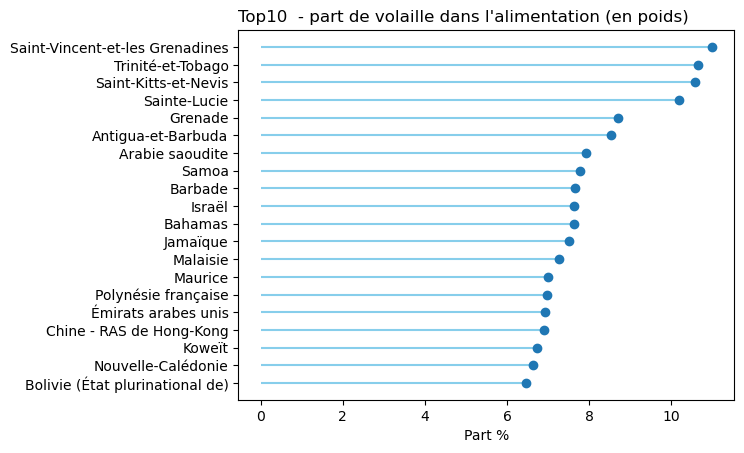

In [15]:
df_ordered =df_Alim_Volailles.nlargest(20,'Part Nourriture (%)').sort_values('Part Nourriture (%)',ascending=True)
my_range = range(1,len(df_ordered)+1)

plt.hlines(y=my_range, xmin=0, xmax=df_ordered['Part Nourriture (%)'], color='skyblue')
plt.plot(df_ordered['Part Nourriture (%)'], my_range, "o")
 
# Add titles and axis names
plt.yticks(my_range, df_ordered['Zone'])
plt.title("Top10  - part de volaille dans l'alimentation (en poids)", loc='left')
plt.xlabel('Part %')


# Show the plot
plt.show()

In [16]:
df_Alim_Volailles['Ratio Export-Import'] = df_Alim_Volailles[
    'Exportations - Quantité (Milliers de tonnes)'] / df_Alim_Volailles[
        'Importations - Quantité (Milliers de tonnes)']

## Fichier population

In [17]:
df_Pop = pd.read_csv('Population_2000_2018.csv')
df_Pop.shape

(4411, 15)

In [18]:
df_Pop.nunique()

Code Domaine                 1
Domaine                      1
Code zone                  238
Zone                       238
Code Élément                 1
Élément                      1
Code Produit                 1
Produit                      1
Code année                  19
Année                       19
Unité                        1
Valeur                    4398
Symbole                      2
Description du Symbole       2
Note                         1
dtype: int64

In [19]:
df_Pop = df_Pop.drop([
    'Code Domaine', 'Domaine', 'Code Élément', 'Élément', 'Code Produit',
    'Produit', 'Code année', 'Unité','Symbole', 'Description du Symbole', 'Note'
],
         axis=1)

In [20]:
df_Pop = df_Pop.rename(columns={'Valeur': 'Population (x1000)'})

df_Pop_transpose = pd.crosstab(
    index=[df_Pop['Code zone'], df_Pop['Zone']],
    values=df_Pop['Population (x1000)'],
    columns=df_Pop['Année'],
    aggfunc='sum')
df_Pop_transpose

,Année,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
Code zone,Zone,,,,,,,,,,,,,,,,,,,
1,Arménie,3069.591,3050.687,3033.978,3017.932,3000.720,2981.269,2958.307,2932.618,2907.618,2888.092,2877.319,2876.538,2884.234,2897.588,2912.409,2925.553,2936.143,2944.791,2951.745
2,Afghanistan,20779.953,21606.988,22600.770,23680.871,24726.684,25654.277,26433.049,27100.536,27722.276,28394.813,29185.507,30117.413,31161.376,32269.589,33370.794,34413.603,35383.032,36296.113,37171.921
3,Albanie,3129.243,3129.704,3126.187,3118.023,3104.892,3086.810,3063.021,3033.998,3002.678,2973.048,2948.023,2928.592,2914.096,2903.790,2896.305,2890.513,2886.438,2884.169,2882.740
4,Algérie,31042.235,31451.514,31855.109,32264.157,32692.163,33149.724,33641.002,34166.972,34730.608,35333.881,35977.455,36661.445,37383.895,38140.133,38923.692,39728.025,40551.392,41389.189,42228.408
5,Samoa américaines,57.821,58.494,59.080,59.504,59.681,59.562,59.107,58.365,57.492,56.683,56.079,55.759,55.667,55.713,55.791,55.812,55.741,55.620,55.465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279,Curaçao,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,152.315,154.817,156.794,158.422,159.847,161.052,161.997,162.752
280,Sint Maarten (partie néerlandaise),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.058,36.241,37.583,38.876,39.968,40.808,41.444,41.940
281,Saint-Martin (partie française),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.446,37.009,36.453,36.015,35.858,36.065,36.560,37.264


In [21]:
df_Pop_transpose.isna().sum()

Année
2000    9
2001    9
2002    9
2003    9
2004    9
2005    9
2006    8
2007    8
2008    8
2009    8
2010    8
2011    3
2012    2
2013    2
2014    2
2015    2
2016    2
2017    2
2018    2
dtype: int64

In [22]:
df_Pop_Nan= df_Pop_transpose[df_Pop_transpose.isna().any(axis=1)]
df_Pop_Nan

,Année,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
Code zone,Zone,,,,,,,,,,,,,,,,,,,
186,Serbie-et-Monténégro,10101.175,10023.939,9959.836,9906.313,9857.775,9810.216,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
206,Soudan (ex),33474.409,34418.875,35393.004,36396.195,37427.544,38485.448,39569.229,40675.760,41797.776,42926.047,44053.377,45180.380,NaN,NaN,NaN,NaN,NaN,NaN,NaN
272,Serbie,NaN,NaN,NaN,NaN,NaN,NaN,9145.914,9101.185,9060.103,9023.357,8991.254,8963.769,8940.113,8918.904,8898.289,8876.777,8853.963,8829.628,8802.754
273,Monténégro,NaN,NaN,NaN,NaN,NaN,NaN,617.860,619.555,621.320,622.939,624.275,625.270,625.925,626.345,626.645,626.956,627.264,627.563,627.809
276,Soudan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36193.783,37072.550,37977.655,38902.950,39847.439,40813.397,41801.533
277,Soudan du Sud,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10113.649,10355.035,10554.880,10715.658,10832.518,10910.763,10975.927
278,"Bonaire, Saint-Eustache et Saba",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.993,22.842,23.505,24.070,24.570,25.020,25.401,25.711
279,Curaçao,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,152.315,154.817,156.794,158.422,159.847,161.052,161.997,162.752
280,Sint Maarten (partie néerlandaise),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.058,36.241,37.583,38.876,39.968,40.808,41.444,41.940


In [23]:
TotalNan = df_Pop_Nan[2018].sum()
df_Pop2018 = df_Pop_transpose[2018].sum()
PartPopNan = TotalNan / df_Pop2018
print("Les pays avec des données manquantes représentent "+ str(PartPopNan) +"% de la population mondiale" )


Les pays avec des données manquantes représentent 0.00818798172459847% de la population mondiale


In [24]:
#on ne garde que les valeurs après 2011 
df_PopFinal = df_Pop[df_Pop.loc[:,'Année']>2011]

df_PopFinal.loc[:,'Pop_log']=np.log(df_PopFinal.loc[:,'Population (x1000)'])

C:\Users\julie\AppData\Local\Temp\ipykernel_12432\1785851374.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_PopFinal.loc[:,'Pop_log']=np.log(df_PopFinal.loc[:,'Population (x1000)'])


In [25]:
#On calcul la croissance moyenne annuelle de la population sur la période 2012-2018
df_PopFinal['Evo'] = df_PopFinal.groupby(
    'Zone')['Population (x1000)'].pct_change() * 100
df_PopFinal['EvoPop'] = df_PopFinal.groupby(['Zone'])['Evo'].transform('mean')

df_PopFinal = df_PopFinal[[
    'Code zone', 'Zone', 'Année', 'Population (x1000)', 'Pop_log', 'EvoPop'
]]

C:\Users\julie\AppData\Local\Temp\ipykernel_12432\2692423945.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_PopFinal['Evo'] = df_PopFinal.groupby(
C:\Users\julie\AppData\Local\Temp\ipykernel_12432\2692423945.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_PopFinal['EvoPop'] = df_PopFinal.groupby(['Zone'])['Evo'].transform('mean')


In [26]:
df_PopFinal.describe()

,Code zone,Année,Population (x1000),Pop_log,EvoPop
count,1652.000000,1652.000000,1.652000e+03,1652.000000,1652.000000
mean,134.894068,2015.000000,3.126898e+04,7.872820,1.218595
std,77.904205,2.000606,1.295407e+05,2.779654,1.249064
min,1.000000,2012.000000,7.930000e-01,-0.231932,-3.068001
25%,68.750000,2013.000000,3.783410e+02,5.935796,0.369597
50%,133.500000,2015.000000,5.095075e+03,8.536025,1.061695
75%,198.250000,2017.000000,1.930666e+04,9.868188,2.073860
max,299.000000,2018.000000,1.427648e+06,14.171539,5.532946


## Regions

In [27]:
df_Region = pd.read_csv("GroupesPays.csv")
#Par simplicification on rattache les Caraïbes et l'Amérique centrale à l'Amérique du sud.
df_Region['Groupe de pays'].replace(['Caraïbes','Amérique centrale'],'Amérique du Sud',inplace=True)
df_Region['Code ISO3'] = df_Region['Code ISO3'].replace('COG','COD')
df_Region

,Code Groupe de pays,Groupe de pays,Code Pays,Pays,Code M49,Code ISO2,Code ISO3
0,5100,Afrique,612,"Afrique Centrale, non spécifié",17.04,F612,F612
1,5100,Afrique,605,"Afrique de l'Est, non spécifié",219.00,F605,F605
2,5100,Afrique,616,"Afrique de l'Ouest, non spécifié",875.00,F616,F616
3,5100,Afrique,615,"Afrique du Nord, non spécifié",290.00,F615,F615
4,5100,Afrique,202,Afrique du Sud,710.00,ZA,ZAF
...,...,...,...,...,...,...,...
2546,5828,"Western Asia (exc. Armenia, Azerbaijan, Cyprus, Israel and Georgia)",212,République arabe syrienne,760.00,SY,SYR
2547,5828,"Western Asia (exc. Armenia, Azerbaijan, Cyprus, Israel and Georgia)",223,Turquie,792.00,TR,TUR
2548,5828,"Western Asia (exc. Armenia, Azerbaijan, Cyprus, Israel and Georgia)",249,Yémen,887.00,YE,YEM
2549,5828,"Western Asia (exc. Armenia, Azerbaijan, Cyprus, Israel and Georgia)",247,Yemen Dém,720.00,F247,F247


In [28]:
df_Region.rename(columns={'Pays':'Zone'},inplace = True)

df_Region.drop(['Code Groupe de pays', 'Code Pays','Code ISO2'], axis=1,inplace=True)

df_Region['Zone'].replace({'Pays-Bas (Royaume des)':'Pays-Bas'},inplace=True)

In [29]:

ListReg = ['Asie','Amérique septentrionale','Amérique centrale','Amérique du Sud','Europe','Océanie','Afrique']
df_Region = df_Region[df_Region['Groupe de pays'].isin(ListReg)]


## Historique consomation viandes

In [30]:
df_Hist_Viande = pd.read_csv('Hist_Viande.csv')

df_Hist_Viande.head()


,Code Domaine,Domaine,Code zone (M49),Zone,Code Élément,Élément,Code Produit (CPC),Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole
0,FBS,Bilans Alimentaires (2010-),4,Afghanistan,5511,Production,S2731,Viande de Bovins,2010,2010,Milliers de tonnes,131.0,I,Valeur imputée
1,FBS,Bilans Alimentaires (2010-),4,Afghanistan,5511,Production,S2731,Viande de Bovins,2011,2011,Milliers de tonnes,138.0,I,Valeur imputée
2,FBS,Bilans Alimentaires (2010-),4,Afghanistan,5511,Production,S2731,Viande de Bovins,2012,2012,Milliers de tonnes,139.0,I,Valeur imputée
3,FBS,Bilans Alimentaires (2010-),4,Afghanistan,5511,Production,S2731,Viande de Bovins,2013,2013,Milliers de tonnes,134.0,I,Valeur imputée
4,FBS,Bilans Alimentaires (2010-),4,Afghanistan,5511,Production,S2731,Viande de Bovins,2014,2014,Milliers de tonnes,121.0,I,Valeur imputée


Suppression des colonnes inutiles

In [31]:
df_Hist_Viande = df_Hist_Viande.drop(['Code Domaine', 'Domaine', 'Code Élément',
        'Code Produit (CPC)','Code année',
       'Unité', 'Symbole', 'Description du Symbole'],axis=1)

In [32]:
df_Hist_Viande_Transpose = pd.crosstab(
index=[df_Hist_Viande['Code zone (M49)'],df_Hist_Viande['Zone'],df_Hist_Viande['Produit'],df_Hist_Viande['Année']],
    values=df_Hist_Viande['Valeur'],columns = df_Hist_Viande['Élément'],aggfunc= 'sum')

In [33]:
df_Hist_Viande_Transpose = df_Hist_Viande_Transpose.drop(['Alimentation pour touristes', 'Aliments pour animaux',
       'Autres utilisations (non alimentaire)',
       'Disponibilité alimentaire (Kcal)',
       'Disponibilité alimentaire (Kcal/personne/jour)',
       
       'Disponibilité de matière grasse en quantité (g)',
       'Disponibilité de matière grasse en quantité (g/personne/jour)',
       'Disponibilité de protéines en quantité (g)',
       'Disponibilité de protéines en quantité (g/personne/jour)',
       'Disponibilité intérieure', 'Exportations - Quantité',
       'Importations - Quantité', 'Pertes', 'Production',
       'Résidus', 'Traitement', 'Variation de stock'],axis=1)

In [34]:
df_Hist_Viande_Transpose = df_Hist_Viande_Transpose.reset_index()
df_Hist_Viande_Transpose

Élément,Code zone (M49),Zone,Produit,Année,Disponibilité alimentaire en quantité (kg/personne/an),Nourriture
0,4,Afghanistan,Viande d'Ovins/Caprins,2010,4.87,142.0
1,4,Afghanistan,Viande d'Ovins/Caprins,2011,4.52,136.0
2,4,Afghanistan,Viande d'Ovins/Caprins,2012,4.92,153.0
3,4,Afghanistan,Viande d'Ovins/Caprins,2013,5.08,164.0
4,4,Afghanistan,Viande d'Ovins/Caprins,2014,4.96,166.0
...,...,...,...,...,...,...
9911,894,Zambie,"Viande, Autre",2016,2.63,43.0
9912,894,Zambie,"Viande, Autre",2017,2.37,40.0
9913,894,Zambie,"Viande, Autre",2018,2.32,40.0
9914,894,Zambie,"Viande, Autre",2019,2.26,40.0


In [35]:
#On ne garde que la consommation de viande de volaille
df_Hist_Volaille = df_Hist_Viande_Transpose[df_Hist_Viande_Transpose['Produit']=='Viande de Volailles']
df_Hist_Volaille ['Evo'] = df_Hist_Volaille.groupby('Zone')['Disponibilité alimentaire en quantité (kg/personne/an)'].pct_change()*100
df_Hist_Volaille ['EvoConso10']=df_Hist_Volaille .groupby(['Zone'])['Evo'].transform('mean')

df_Hist_Volaille = df_Hist_Volaille[['Code zone (M49)','EvoConso10']]

C:\Users\julie\AppData\Local\Temp\ipykernel_12432\2997198094.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Hist_Volaille ['Evo'] = df_Hist_Volaille.groupby('Zone')['Disponibilité alimentaire en quantité (kg/personne/an)'].pct_change()*100
C:\Users\julie\AppData\Local\Temp\ipykernel_12432\2997198094.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Hist_Volaille ['EvoConso10']=df_Hist_Volaille .groupby(['Zone'])['Evo'].transform('mean')


In [36]:
df_Hist_Volaille=df_Hist_Volaille.drop_duplicates()
df_Hist_Volaille.describe()

Élément,Code zone (M49),EvoConso10
count,186.000000,186.000000
mean,425.801075,3.769549
std,251.994719,15.580590
min,4.000000,-43.896104
25%,205.000000,0.511814
50%,420.000000,2.083073
75%,640.000000,4.375987
max,894.000000,199.147210


## Données économiques 

In [37]:
#on charge le fichier indiquant l'indice de facilité des affaires (1= grande facilité)
df_Business=pd.read_csv('Business2019.csv',skiprows=4)
df_Business=df_Business.drop(columns=df_Business.iloc[:,3:-5],axis=1)


In [38]:
df_Business= df_Business[['Country Name', 'Country Code',  '2019']]
df_Business.rename(columns={'2019':'Business risk'},inplace=True)

In [39]:
df_Business['Business risk']=df_Business['Business risk'].fillna(df_Business['Business risk'].median())

In [40]:
df_Business.describe()

,Business risk
count,266.000000
mean,95.947368
std,46.176579
min,1.000000
25%,68.250000
50%,96.000000
75%,123.750000
max,190.000000


In [41]:
df_Business.isna().mean()

Country Name     0.007519
Country Code     0.000000
Business risk    0.000000
dtype: float64

In [42]:
df_Business = df_Business.dropna()

In [43]:
#Fichier donnant un indice de coût pour les aliments d'origine animale 
df_MeatCost = pd.read_csv('MeatCost2017.csv')
df_MeatCost.head()
df_MeatCost.rename(columns={'Valeur' : 'Animal food Cost Index'},inplace=True)


In [44]:
df_MeatCost = df_MeatCost.drop(['Code Domaine', 'Domaine','Zone', 'Code Élément','Produit',
       'Élément', 'Code Produit',  'Code année', 'Année', 'Unité',
        'Symbole', 'Description du Symbole'],axis=1)

In [45]:
df_MeatCost.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169 entries, 0 to 168
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Code zone (M49)         169 non-null    int64  
 1   Animal food Cost Index  169 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 2.8 KB


In [46]:
#Fichier indiquant les prix à la production à la tonne de la viande de volaille en 2018 (USD / Tonne)
df_ProductionCost = pd.read_csv('ProductionPrice2018.csv')
df_ProductionCost.rename(columns={'Valeur' : 'Production Cost'},inplace=True)


In [47]:
df_ProductionCost = df_ProductionCost.drop(['Code Domaine','Zone', 'Domaine', 'Code Élément',
       'Élément', 'Code Produit (CPC)', 'Produit', 'Code année', 'Année',
       'Code Mois', 'Mois', 'Unité', 'Symbole',
       'Description du Symbole'],axis =1)

In [48]:
df_ProductionCost.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Code zone (M49)  66 non-null     int64  
 1   Production Cost  66 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 1.2 KB


## Contexte politique



In [49]:
#On charge le fichier indiquant la stabilité politique des pays ainsi que leur PIB en 2018
PoliticSrc = pd.read_csv('Politic_PIB2018.csv')
PoliticSrc = PoliticSrc.drop(['Code Domaine', 'Domaine', 'Code Élément'
       , 'Code Produit', 'Code année', 'Unité','Élément','Année',
        'Symbole', 'Description du Symbole', 'Note'],axis=1)
PoliticSrc

,Code zone (M49),Zone,Produit,Valeur
0,4,Afghanistan,"PIB par habitant, ($ PPA internationaux constants de 2017)",2033.80
1,4,Afghanistan,Stabilité politique et absence de violence/terrorisme (indice),-2.76
2,710,Afrique du Sud,"PIB par habitant, ($ PPA internationaux constants de 2017)",13875.90
3,710,Afrique du Sud,Stabilité politique et absence de violence/terrorisme (indice),-0.23
4,8,Albanie,"PIB par habitant, ($ PPA internationaux constants de 2017)",13317.10
...,...,...,...,...
381,887,Yémen,Stabilité politique et absence de violence/terrorisme (indice),-3.01
382,894,Zambie,"PIB par habitant, ($ PPA internationaux constants de 2017)",3521.50
383,894,Zambie,Stabilité politique et absence de violence/terrorisme (indice),0.09
384,716,Zimbabwe,"PIB par habitant, ($ PPA internationaux constants de 2017)",3923.00


In [50]:
Politic = pd.crosstab(
    index=[PoliticSrc['Code zone (M49)'],PoliticSrc['Zone']],
    values=PoliticSrc['Valeur'],
    columns=PoliticSrc['Produit'],
    aggfunc='sum')
Politic = Politic.reset_index()


In [51]:
Politic.isna().mean()

Produit
Code zone (M49)                                                   0.000
Zone                                                              0.000
PIB par habitant, ($ PPA internationaux constants de 2017)        0.065
Stabilité politique et absence de violence/terrorisme (indice)    0.005
dtype: float64

In [52]:
Politic[Politic['Zone'].str.contains('Chine')]

Produit,Code zone (M49),Zone,"PIB par habitant, ($ PPA internationaux constants de 2017)",Stabilité politique et absence de violence/terrorisme (indice)
38,158,"Chine, Taiwan Province de",NaN,0.85
39,159,Chine,15416.7,NaN
79,344,Chine - RAS de Hong-Kong,61055.3,0.78
107,446,Chine - RAS de Macao,132374.0,1.25


In [53]:
Politic.describe()

Produit,Code zone (M49),"PIB par habitant, ($ PPA internationaux constants de 2017)",Stabilité politique et absence de violence/terrorisme (indice)
count,200.000000,187.000000,199.000000
mean,425.045000,21323.554545,-0.057638
std,254.716185,22504.303158,0.995211
min,4.000000,761.500000,-3.010000
25%,203.750000,5046.600000,-0.635000
50%,420.000000,13634.700000,0.020000
75%,642.250000,30544.900000,0.795000
max,894.000000,132374.000000,1.930000


## Environnement

In [54]:
#On charge le fichier indqiquant la distance entre la France et les autre pays du monde
dist = pd.read_csv('Distances-France.csv')
dist['Log_dist'] = np.log(dist['dist-France (km)'])

In [55]:
dist

,iso3,pays,dist-France (km),Log_dist
0,ABW,Aruba,7685,8.947026
1,AFG,Afghanistan,5590,8.628735
2,AGO,Angola,6510,8.781095
3,AIA,Anguilla,6710,8.811354
4,ALB,Albanie,1603,7.379632
...,...,...,...,...
219,SRB,Serbie et Monténégro (ex-Yougoslavie),1449,7.278629
220,ZAF,Afrique du Sud,9353,9.143452
221,ZAR,"Congo, Rép. dém. du",6049,8.707648
222,ZMB,Zambie,7604,8.936430


# Nettoyage des données

## Jointure des tables

In [56]:
df_Pop2018 = df_PopFinal[df_PopFinal['Année']==2018]
df_Pop2018 = df_Pop2018.drop(['Zone', 'Année'],axis=1)


In [57]:

Datamerge0= pd.merge(dist,df_Business,left_on='iso3',right_on='Country Code',how='left')
DataMerge = pd.merge(df_Region,Datamerge0,left_on='Code ISO3',right_on='iso3',how = 'left')
DataMerge1 = pd.merge(df_Pop2018 , df_Alim_Volailles,on='Code zone',how = 'right')
DataMerge2 = pd.merge(DataMerge,DataMerge1,on='Zone' ,how = 'right')
DataMerge2['Code M49'] = DataMerge2['Code M49'].astype(int)
DataMerge3 = pd.merge(DataMerge2,df_MeatCost,right_on='Code zone (M49)',left_on=('Code M49'),how = 'left')
DataMerge4 = pd.merge(DataMerge3,df_ProductionCost,left_on='Code M49',right_on='Code zone (M49)',how = 'left')
DataMerge5 = pd.merge(DataMerge4,df_Hist_Volaille,left_on='Code M49',right_on='Code zone (M49)',how = 'left')
DataFinal = pd.merge(DataMerge5,Politic,left_on='Code M49',right_on='Code zone (M49)',how = 'left')




C:\Users\julie\AppData\Local\Temp\ipykernel_12432\3245989593.py:9: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Code zone (M49)_x'} in the result is deprecated and will raise a MergeError in a future version.
  DataFinal = pd.merge(DataMerge5,Politic,left_on='Code M49',right_on='Code zone (M49)',how = 'left')


In [58]:
DataFinal.rename(columns={'Zone_x':'Zone'},inplace=True)

In [59]:
DataFinal.columns

Index(['Groupe de pays', 'Zone', 'Code M49', 'Code ISO3', 'iso3', 'pays',
       'dist-France (km)', 'Log_dist', 'Country Name', 'Country Code',
       'Business risk', 'Code zone', 'Population (x1000)', 'Pop_log', 'EvoPop',
       'Disponibilité alimentaire en quantité (kg/personne/an)',
       'Disponibilité intérieure (Milliers de tonnes)',
       'Exportations - Quantité (Milliers de tonnes)',
       'Importations - Quantité (Milliers de tonnes)',
       'Nourriture (Milliers de tonnes)', 'Production (Milliers de tonnes)',
       'Résidus (Milliers de tonnes)',
       'Variation de stock (Milliers de tonnes)', 'Part Nourriture (%)',
       'Ratio Export-Import', 'Code zone (M49)_x', 'Animal food Cost Index',
       'Code zone (M49)_y', 'Production Cost', 'Code zone (M49)_x',
       'EvoConso10', 'Code zone (M49)_y', 'Zone_y',
       'PIB par habitant, ($ PPA internationaux constants de 2017)',
       'Stabilité politique et absence de violence/terrorisme (indice)'],
      dtype='ob

In [60]:
DataFinal.drop([ 'Code M49', 'Code zone', 'iso3', 'pays','Country Name','Country Code',
       'Code zone (M49)_x','Code zone (M49)_y', 'Code zone (M49)_x','Code zone (M49)_y',
       'Zone_y'],axis=1,inplace=True)

In [61]:
#On regroupe les pays "assimilés" à la Chine sous le nom 'Chine' pour simplifier
ListChine= DataFinal[DataFinal['Zone'].str.contains('Chine')]['Zone'].tolist()

DataFinal['Zone'].replace(ListChine,'Chine',inplace=True)


In [62]:
DataChine = DataFinal[DataFinal['Zone']=='Chine']

DataChine['PopWeight'] = DataChine.groupby('Zone')[
    'Population (x1000)'].transform(lambda x: ((x / DataChine.groupby(
        'Zone')['Population (x1000)'].transform('sum'))))

#On pondère les valeurs des variables par la population
for i in range(5,len(DataFinal.columns)):    
    DataChine[DataChine.columns[i]] = DataChine.groupby('Zone')[DataChine.columns[i]].transform(lambda x: (x * DataChine['PopWeight']).sum())

    
DataFinal=DataFinal.drop(index=[61,89,145])
#DataFinal=DataFinal.drop(columns='PopWeight',axis=1)
DataFinal[DataFinal['Zone'].str.contains('Chine')]
DataFinal.replace([np.inf, -np.inf], np.nan, inplace=True)


C:\Users\julie\AppData\Local\Temp\ipykernel_12432\4111684466.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DataChine['PopWeight'] = DataChine.groupby('Zone')[
C:\Users\julie\AppData\Local\Temp\ipykernel_12432\4111684466.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DataChine[DataChine.columns[i]] = DataChine.groupby('Zone')[DataChine.columns[i]].transform(lambda x: (x * DataChine['PopWeight']).sum())
C:\Users\julie\AppData\Local\Temp\ipykernel_12432\4111684466.py:9: SettingWithCopyWarning: 
A va

## Traitement des valeurs manquantes

In [63]:
DataFinal.isna().mean().sort_values()

Groupe de pays                                                    0.000000
Zone                                                              0.000000
Code ISO3                                                         0.000000
Population (x1000)                                                0.000000
Pop_log                                                           0.000000
EvoPop                                                            0.000000
Disponibilité alimentaire en quantité (kg/personne/an)            0.000000
EvoConso10                                                        0.000000
Part Nourriture (%)                                               0.000000
dist-France (km)                                                  0.005917
Log_dist                                                          0.005917
Business risk                                                     0.005917
Disponibilité intérieure (Milliers de tonnes)                     0.011834
Importations - Quantité (

In [64]:
DataFinal.describe()

,dist-France (km),Log_dist,Business risk,Population (x1000),Pop_log,EvoPop,Disponibilité alimentaire en quantité (kg/personne/an),Disponibilité intérieure (Milliers de tonnes),Exportations - Quantité (Milliers de tonnes),Importations - Quantité (Milliers de tonnes),Nourriture (Milliers de tonnes),Production (Milliers de tonnes),Résidus (Milliers de tonnes),Variation de stock (Milliers de tonnes),Part Nourriture (%),Ratio Export-Import,Animal food Cost Index,Production Cost,EvoConso10,"PIB par habitant, ($ PPA internationaux constants de 2017)",Stabilité politique et absence de violence/terrorisme (indice)
count,168.000000,168.000000,168.000000,1.690000e+02,169.000000,169.000000,169.000000,167.000000,132.000000,167.000000,167.000000,165.000000,161.000000,166.000000,169.000000,118.000000,148.000000,63.000000,169.000000,162.000000,166.000000
mean,6013.529762,8.400368,92.619048,4.388359e+04,9.018811,1.325701,19.855325,693.455090,130.106061,84.604790,661.682635,734.260606,-2.111801,13.819277,2.872265,17.851766,0.874453,1806.712698,2.987457,19851.009259,-0.091807
std,3940.502761,0.905934,52.691488,1.555395e+05,1.950877,1.199660,15.719548,2206.002159,517.313572,177.109964,2155.073342,2522.985668,9.693422,76.017645,2.396821,134.780822,0.213743,1174.820512,4.961968,19257.251491,0.900531
min,262.000000,5.568345,1.000000,5.244100e+01,3.959689,-1.383817,0.130000,2.000000,0.000000,0.000000,2.000000,0.000000,-78.000000,-119.000000,0.035934,0.000000,0.377000,713.000000,-8.588701,933.100000,-3.010000
25%,2839.000000,7.948597,46.750000,2.882740e+03,7.966497,0.482614,6.380000,31.000000,0.000000,3.000000,29.000000,14.000000,0.000000,0.000000,1.125170,0.000000,0.713000,1052.550000,0.475901,5138.675000,-0.627500
50%,5586.000000,8.628018,95.500000,9.949537e+03,9.205281,1.195719,17.620000,98.000000,2.500000,16.000000,98.000000,71.000000,0.000000,0.000000,2.089982,0.087121,0.850500,1316.000000,2.018429,13386.050000,-0.020000
75%,8680.000000,9.068775,136.250000,3.152803e+04,10.358632,2.190952,28.980000,364.500000,30.500000,78.500000,347.000000,392.000000,0.000000,6.750000,3.826232,0.747984,1.012000,2184.750000,4.388349,28986.775000,0.650000
max,19263.000000,9.865941,188.000000,1.427648e+06,14.171539,5.532946,72.310000,18266.000000,4223.000000,1069.000000,18100.000000,21914.000000,0.000000,859.000000,10.992870,1407.666667,1.583000,7353.000000,35.414172,115050.000000,1.530000


In [65]:
DataFinal.columns

Index(['Groupe de pays', 'Zone', 'Code ISO3', 'dist-France (km)', 'Log_dist',
       'Business risk', 'Population (x1000)', 'Pop_log', 'EvoPop',
       'Disponibilité alimentaire en quantité (kg/personne/an)',
       'Disponibilité intérieure (Milliers de tonnes)',
       'Exportations - Quantité (Milliers de tonnes)',
       'Importations - Quantité (Milliers de tonnes)',
       'Nourriture (Milliers de tonnes)', 'Production (Milliers de tonnes)',
       'Résidus (Milliers de tonnes)',
       'Variation de stock (Milliers de tonnes)', 'Part Nourriture (%)',
       'Ratio Export-Import', 'Animal food Cost Index', 'Production Cost',
       'EvoConso10',
       'PIB par habitant, ($ PPA internationaux constants de 2017)',
       'Stabilité politique et absence de violence/terrorisme (indice)'],
      dtype='object')

In [66]:
#On remplace les valeurs manquantes par la médiane de la colonne
ListFillNaMed = [ 'Ratio Export-Import',
    'dist-France (km)', 'Log_dist',
    'Disponibilité alimentaire en quantité (kg/personne/an)',
    'Disponibilité intérieure (Milliers de tonnes)',
    'Exportations - Quantité (Milliers de tonnes)',
    'Importations - Quantité (Milliers de tonnes)',
    'Nourriture (Milliers de tonnes)', 'Production (Milliers de tonnes)',
    'Résidus (Milliers de tonnes)', 'Variation de stock (Milliers de tonnes)',
    'Part Nourriture (%)', 'Animal food Cost Index', 'Production Cost',
    'PIB par habitant, ($ PPA internationaux constants de 2017)',
    'Stabilité politique et absence de violence/terrorisme (indice)','Business risk']
    

DataFinal[ListFillNaMed] = DataFinal[ListFillNaMed].fillna(
    DataFinal[ListFillNaMed].median())

In [67]:
DataFinal.isna().mean()

Groupe de pays                                                    0.0
Zone                                                              0.0
Code ISO3                                                         0.0
dist-France (km)                                                  0.0
Log_dist                                                          0.0
Business risk                                                     0.0
Population (x1000)                                                0.0
Pop_log                                                           0.0
EvoPop                                                            0.0
Disponibilité alimentaire en quantité (kg/personne/an)            0.0
Disponibilité intérieure (Milliers de tonnes)                     0.0
Exportations - Quantité (Milliers de tonnes)                      0.0
Importations - Quantité (Milliers de tonnes)                      0.0
Nourriture (Milliers de tonnes)                                   0.0
Production (Milliers

In [68]:
DataFinal

,Groupe de pays,Zone,Code ISO3,dist-France (km),Log_dist,Business risk,Population (x1000),Pop_log,EvoPop,Disponibilité alimentaire en quantité (kg/personne/an),Disponibilité intérieure (Milliers de tonnes),Exportations - Quantité (Milliers de tonnes),Importations - Quantité (Milliers de tonnes),Nourriture (Milliers de tonnes),Production (Milliers de tonnes),Résidus (Milliers de tonnes),Variation de stock (Milliers de tonnes),Part Nourriture (%),Ratio Export-Import,Animal food Cost Index,Production Cost,EvoConso10,"PIB par habitant, ($ PPA internationaux constants de 2017)",Stabilité politique et absence de violence/terrorisme (indice)
0,Asie,Arménie,ARM,3434.0,8.141481,47.0,2951.745,7.990152,0.386412,16.06,47.0,0.0,35.0,47.0,11.0,0.0,-2.0,1.595771,0.000000,0.9730,819.5,1.907957,12715.1,-0.44
1,Asie,Afghanistan,AFG,5590.0,8.628735,173.0,37171.921,10.523309,2.984051,1.53,57.0,2.5,29.0,55.0,28.0,0.0,0.0,0.428200,0.087121,0.8505,1316.0,-1.837373,2033.8,-2.76
2,Europe,Albanie,ALB,1603.0,7.379632,82.0,2882.740,7.966497,-0.180090,16.36,47.0,0.0,38.0,47.0,13.0,0.0,4.0,1.297908,0.000000,1.2040,2829.8,0.726132,13317.1,0.37
3,Afrique,Algérie,DZA,1340.0,7.200425,157.0,42228.408,10.650848,2.051651,6.38,277.0,0.0,2.0,264.0,275.0,0.0,0.0,0.798788,0.000000,0.9640,1316.0,-1.266553,11630.7,-0.84
4,Afrique,Angola,AGO,6510.0,8.781095,177.0,30809.787,10.335588,3.469693,10.56,319.0,0.0,277.0,315.0,42.0,0.0,0.0,1.849549,0.000000,1.0110,1316.0,-0.916974,6982.1,-0.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,Europe,Belgique,BEL,262.0,5.568345,46.0,11482.178,9.348551,0.587907,12.65,152.0,656.0,338.0,144.0,463.0,-25.0,-6.0,1.245397,1.940828,0.7450,1030.1,0.655120,51139.1,0.40
168,Europe,Luxembourg,LUX,289.0,5.666427,72.0,604.245,6.403980,2.181583,18.33,11.0,1.0,11.0,11.0,0.0,0.0,0.0,1.853350,0.090909,0.6560,3977.5,0.321323,115050.0,1.36
169,Europe,Serbie,SRB,1449.0,7.278629,44.0,8802.754,9.082820,-0.257724,10.16,90.0,7.0,12.0,90.0,85.0,0.0,0.0,1.363941,0.583333,0.9980,1045.3,5.521856,17452.8,0.01
170,Europe,Monténégro,MNE,5586.0,8.628018,95.5,627.809,6.442236,0.050103,15.98,10.0,0.0,8.0,10.0,4.0,0.0,1.0,1.471387,0.000000,0.8620,1316.0,1.877218,20686.6,0.04


## On redéfini certaines variables à l'unité "habitant"

In [69]:
List_ratiohab =[       
       'Disponibilité intérieure (Milliers de tonnes)',
       'Exportations - Quantité (Milliers de tonnes)',
       'Importations - Quantité (Milliers de tonnes)', 
       'Production (Milliers de tonnes)',
       'Résidus (Milliers de tonnes)',
       'Variation de stock (Milliers de tonnes)', 'Nourriture (Milliers de tonnes)']

for i in List_ratiohab : 

    DataFinal[i] = (DataFinal[i]*1000) / DataFinal['Population (x1000)']



In [70]:
NewName =[
             
       'Disponibilité intérieure (kg/hab)',
       'Exportations - Quantité (kg/hab)',
       'Importations - Quantité (kg/hab)', 
       'Production (kg/hab)',
       'Résidus (kg/hab)',
       'Variation de stock (kg/hab)', 'Nourriture (kg/hab)']

for i in range(0,len(NewName)):
    DataFinal = DataFinal.rename(columns ={List_ratiohab[i] : NewName[i]})

In [71]:
DataFinal

,Groupe de pays,Zone,Code ISO3,dist-France (km),Log_dist,Business risk,Population (x1000),Pop_log,EvoPop,Disponibilité alimentaire en quantité (kg/personne/an),Disponibilité intérieure (kg/hab),Exportations - Quantité (kg/hab),Importations - Quantité (kg/hab),Nourriture (kg/hab),Production (kg/hab),Résidus (kg/hab),Variation de stock (kg/hab),Part Nourriture (%),Ratio Export-Import,Animal food Cost Index,Production Cost,EvoConso10,"PIB par habitant, ($ PPA internationaux constants de 2017)",Stabilité politique et absence de violence/terrorisme (indice)
0,Asie,Arménie,ARM,3434.0,8.141481,47.0,2951.745,7.990152,0.386412,16.06,15.922785,0.000000,11.857393,15.922785,3.726609,0.000000,-0.677565,1.595771,0.000000,0.9730,819.5,1.907957,12715.1,-0.44
1,Asie,Afghanistan,AFG,5590.0,8.628735,173.0,37171.921,10.523309,2.984051,1.53,1.533416,0.067255,0.780159,1.479611,0.753257,0.000000,0.000000,0.428200,0.087121,0.8505,1316.0,-1.837373,2033.8,-2.76
2,Europe,Albanie,ALB,1603.0,7.379632,82.0,2882.740,7.966497,-0.180090,16.36,16.303933,0.000000,13.181903,16.303933,4.509599,0.000000,1.387569,1.297908,0.000000,1.2040,2829.8,0.726132,13317.1,0.37
3,Afrique,Algérie,DZA,1340.0,7.200425,157.0,42228.408,10.650848,2.051651,6.38,6.559565,0.000000,0.047361,6.251716,6.512204,0.000000,0.000000,0.798788,0.000000,0.9640,1316.0,-1.266553,11630.7,-0.84
4,Afrique,Angola,AGO,6510.0,8.781095,177.0,30809.787,10.335588,3.469693,10.56,10.353853,0.000000,8.990650,10.224024,1.363203,0.000000,0.000000,1.849549,0.000000,1.0110,1316.0,-0.916974,6982.1,-0.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,Europe,Belgique,BEL,262.0,5.568345,46.0,11482.178,9.348551,0.587907,12.65,13.237907,57.132018,29.436924,12.541175,40.323360,-2.177287,-0.522549,1.245397,1.940828,0.7450,1030.1,0.655120,51139.1,0.40
168,Europe,Luxembourg,LUX,289.0,5.666427,72.0,604.245,6.403980,2.181583,18.33,18.204536,1.654958,18.204536,18.204536,0.000000,0.000000,0.000000,1.853350,0.090909,0.6560,3977.5,0.321323,115050.0,1.36
169,Europe,Serbie,SRB,1449.0,7.278629,44.0,8802.754,9.082820,-0.257724,10.16,10.224073,0.795206,1.363210,10.224073,9.656069,0.000000,0.000000,1.363941,0.583333,0.9980,1045.3,5.521856,17452.8,0.01
170,Europe,Monténégro,MNE,5586.0,8.628018,95.5,627.809,6.442236,0.050103,15.98,15.928411,0.000000,12.742729,15.928411,6.371365,0.000000,1.592841,1.471387,0.000000,0.8620,1316.0,1.877218,20686.6,0.04


In [72]:
DataFinal.columns



Index(['Groupe de pays', 'Zone', 'Code ISO3', 'dist-France (km)', 'Log_dist',
       'Business risk', 'Population (x1000)', 'Pop_log', 'EvoPop',
       'Disponibilité alimentaire en quantité (kg/personne/an)',
       'Disponibilité intérieure (kg/hab)', 'Exportations - Quantité (kg/hab)',
       'Importations - Quantité (kg/hab)', 'Nourriture (kg/hab)',
       'Production (kg/hab)', 'Résidus (kg/hab)',
       'Variation de stock (kg/hab)', 'Part Nourriture (%)',
       'Ratio Export-Import', 'Animal food Cost Index', 'Production Cost',
       'EvoConso10',
       'PIB par habitant, ($ PPA internationaux constants de 2017)',
       'Stabilité politique et absence de violence/terrorisme (indice)'],
      dtype='object')

# Analyses descritpives univariées

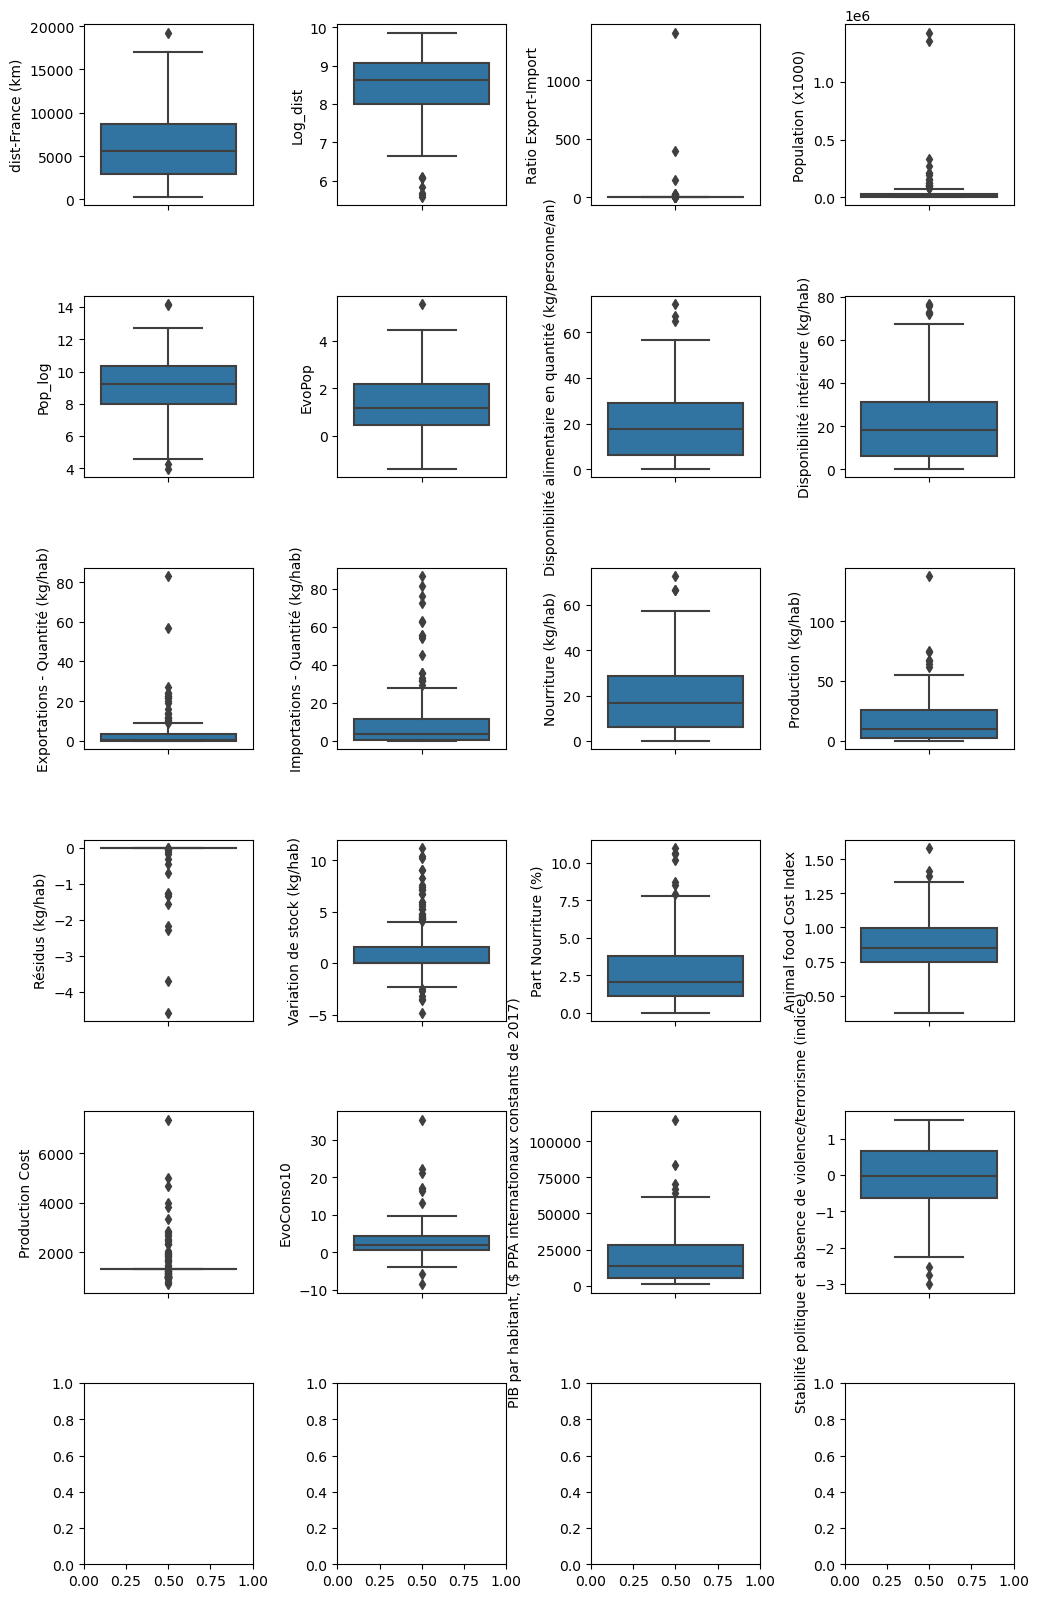

In [73]:
df_box = DataFinal[[ 'dist-France (km)', 'Log_dist','Ratio Export-Import',
       'Population (x1000)', 'Pop_log', 'EvoPop',
       'Disponibilité alimentaire en quantité (kg/personne/an)',
       'Disponibilité intérieure (kg/hab)', 'Exportations - Quantité (kg/hab)',
       'Importations - Quantité (kg/hab)', 'Nourriture (kg/hab)',
       'Production (kg/hab)', 'Résidus (kg/hab)',
       'Variation de stock (kg/hab)', 'Part Nourriture (%)',
       'Animal food Cost Index', 'Production Cost', 'EvoConso10',
       'PIB par habitant, ($ PPA internationaux constants de 2017)',
       'Stabilité politique et absence de violence/terrorisme (indice)']]

col = df_box.columns
lines = int(len(col)/4)+1
fig, axes = plt.subplots(lines,4, figsize=(12,20))

for col , ax  in zip(col,axes.flatten()):
           
    sns.boxplot(data= df_box,y=col , ax=ax  )
    plt.subplots_adjust(wspace=.5, hspace=.5)



***


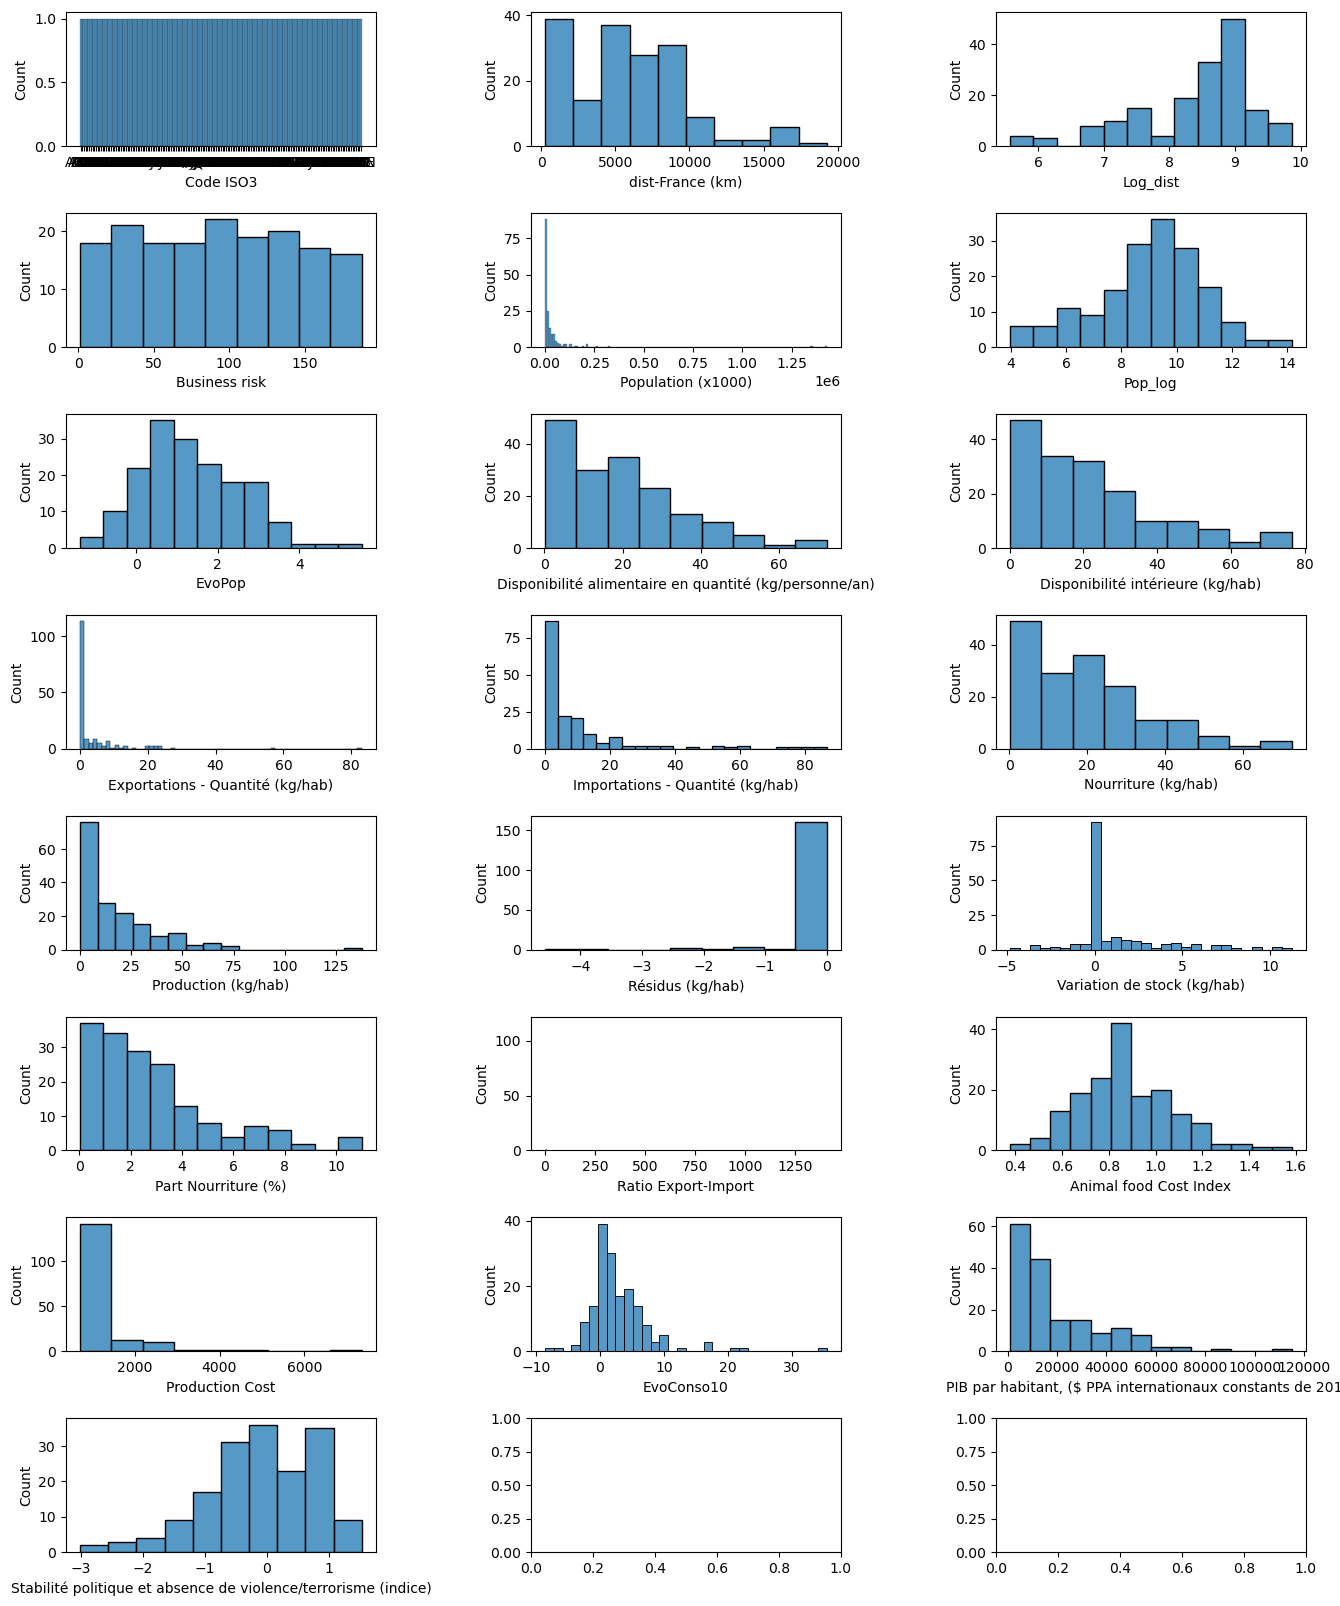

In [74]:
DataFinal_Var = DataFinal.columns[2:]

plot_lines = int(len(DataFinal_Var)/3)+1
fig, axes = plt.subplots(plot_lines, 3, figsize=(16,20))

for DataFinal_Var , ax  in zip(DataFinal_Var,axes.flatten()):
           
    sns.histplot(DataFinal[DataFinal_Var], ax=ax)
    plt.subplots_adjust(wspace=.5, hspace=.5)



> **On filtre ici les outliers**

In [75]:
ListOutliers = []
#'Chine, continentale','Inde','Brésil','Chine - RAS de Hong-Kong',"États-Unis d'Amérique","Chine - RAS de Macao"," Nouvelle-Calédonie"
DataFinal_out = DataFinal[~DataFinal['Zone'].isin(ListOutliers)]

#Permet de filtrer les pays par le nombre d'habitants
#DataFinal_out = DataFinal_out[DataFinal_out['Population (x1000)']>200]

# Analyse mutlivariée : ACP

## Choix des variables 

In [76]:
DataFinal.columns

Index(['Groupe de pays', 'Zone', 'Code ISO3', 'dist-France (km)', 'Log_dist',
       'Business risk', 'Population (x1000)', 'Pop_log', 'EvoPop',
       'Disponibilité alimentaire en quantité (kg/personne/an)',
       'Disponibilité intérieure (kg/hab)', 'Exportations - Quantité (kg/hab)',
       'Importations - Quantité (kg/hab)', 'Nourriture (kg/hab)',
       'Production (kg/hab)', 'Résidus (kg/hab)',
       'Variation de stock (kg/hab)', 'Part Nourriture (%)',
       'Ratio Export-Import', 'Animal food Cost Index', 'Production Cost',
       'EvoConso10',
       'PIB par habitant, ($ PPA internationaux constants de 2017)',
       'Stabilité politique et absence de violence/terrorisme (indice)'],
      dtype='object')

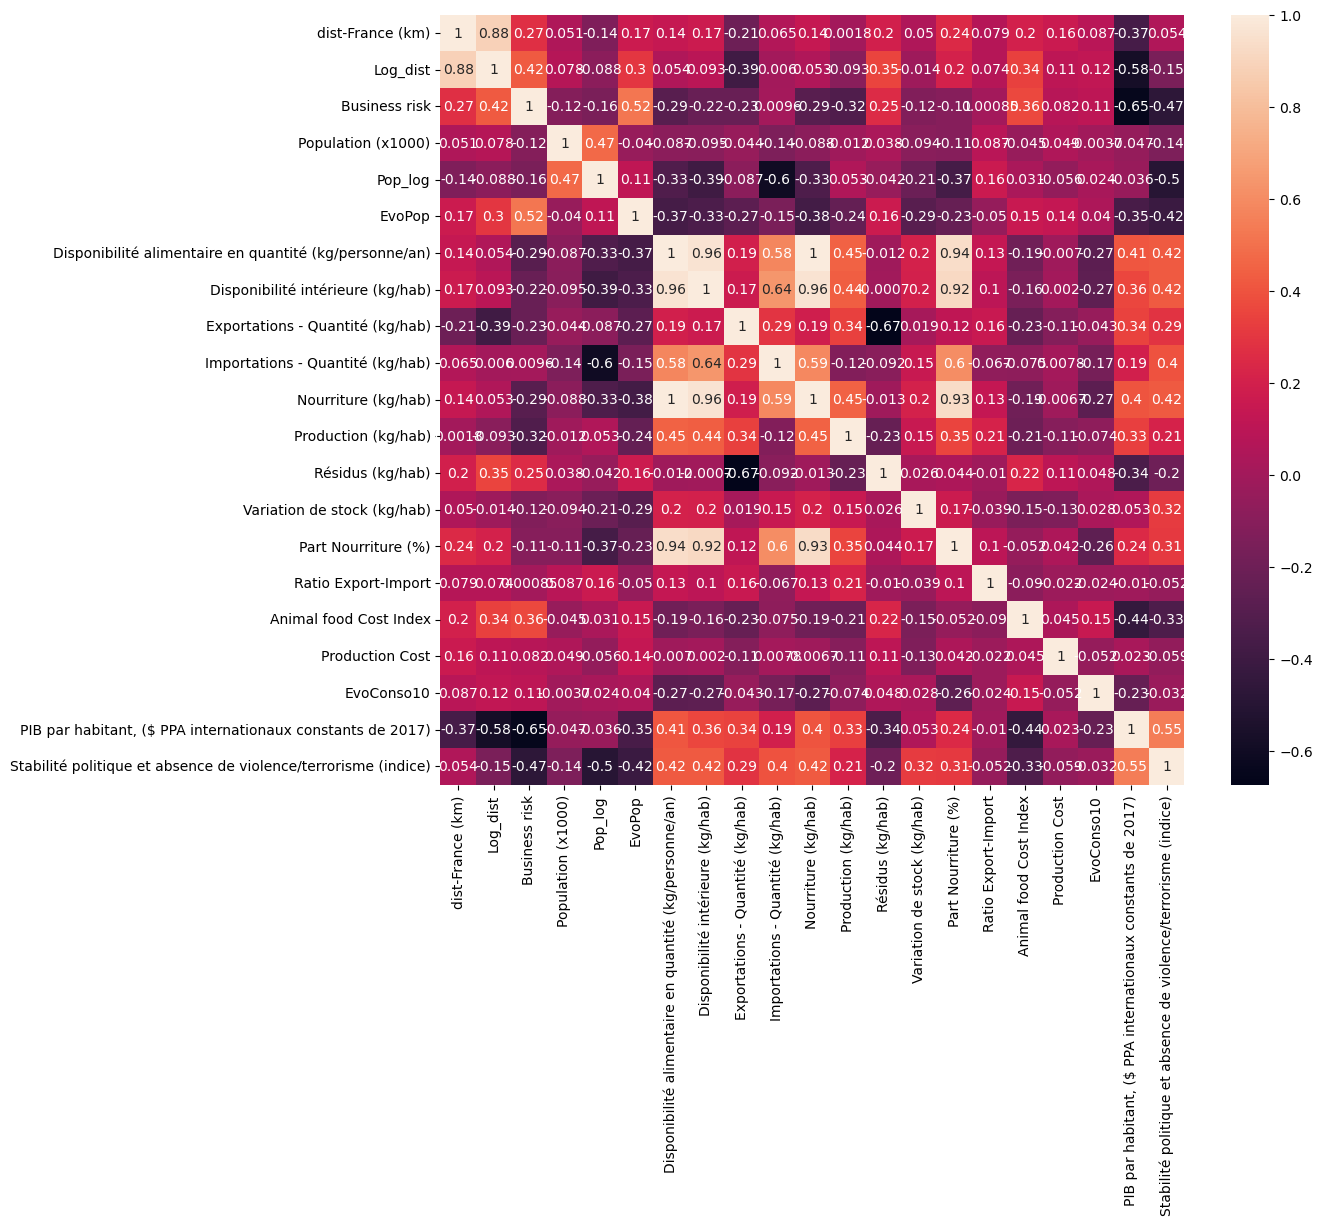

In [77]:
plt.figure(figsize= (12,10))
heatmap = pd.DataFrame(DataFinal,columns=DataFinal.iloc[:,2:].columns)
sns.heatmap(heatmap.corr(),annot=True)
plt.show()

In [78]:
ListVar = ['Code ISO3',
    'Groupe de pays', 'Zone', 'Log_dist',
    'Pop_log', 'EvoPop','Ratio Export-Import',
    'Exportations - Quantité (kg/hab)',
    'Importations - Quantité (kg/hab)',
    'Production (kg/hab)','Variation de stock (kg/hab)',
    'Part Nourriture (%)', 'Animal food Cost Index',
    'Production Cost', 'EvoConso10',
    'PIB par habitant, ($ PPA internationaux constants de 2017)','Business risk',
    'Stabilité politique et absence de violence/terrorisme (indice)'
]

In [79]:
DataFinal_out=DataFinal_out[ListVar]

#On sauvegarde le dataframe dans un fichier .csv
DataFinal_out.to_csv('Datafina_out',index=False)

In [80]:
#on extrait les valeurs du tableau sous forme d'une matrice
X = DataFinal_out.iloc[:,3:].values



In [81]:
X.shape

(169, 15)

In [82]:
pd.DataFrame(X,columns=DataFinal_out.iloc[:,3:].columns).describe()


,Log_dist,Pop_log,EvoPop,Ratio Export-Import,Exportations - Quantité (kg/hab),Importations - Quantité (kg/hab),Production (kg/hab),Variation de stock (kg/hab),Part Nourriture (%),Animal food Cost Index,Production Cost,EvoConso10,"PIB par habitant, ($ PPA internationaux constants de 2017)",Business risk,Stabilité politique et absence de violence/terrorisme (indice)
count,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000
mean,8.401715,9.018811,1.325701,12.490838,3.773488,10.015783,17.236500,1.201796,2.872265,0.871476,1498.928402,2.987457,19583.229882,92.636095,-0.090533
std,0.903404,1.950877,1.199660,112.774652,9.347648,16.343395,19.982974,2.684176,2.396821,0.200095,752.328613,4.961968,18896.014152,52.534902,0.892505
min,5.568345,3.959689,-1.383817,0.000000,0.000000,0.000000,0.000000,-4.806689,0.035934,0.377000,713.000000,-8.588701,933.100000,1.000000,-3.010000
25%,7.990915,7.966497,0.482614,0.008032,0.000000,0.415547,2.222179,0.000000,1.125170,0.745000,1316.000000,0.475901,5193.400000,47.000000,-0.620000
50%,8.628018,9.205281,1.195719,0.087121,0.296712,3.395651,9.656069,0.000000,2.089982,0.850500,1316.000000,2.018429,13386.050000,95.500000,-0.020000
75%,9.067739,10.358632,2.190952,0.416667,3.537352,11.553244,26.033325,1.600595,3.826232,0.998000,1316.000000,4.388349,28318.400000,136.000000,0.650000
max,9.865941,14.171539,5.532946,1407.666667,83.120549,86.677646,137.678012,11.214336,10.992870,1.583000,7353.000000,35.414172,115050.000000,188.000000,1.530000


In [83]:
X = preprocessing.StandardScaler().fit_transform(X)
# méthode fit_transform() sur l'objet StandardScaler() pour normaliser les données

In [84]:
X.shape


(169, 15)

<br><br>On vérifie que nos données sont bien centrées / réduites: <br><br>

In [85]:
idx = ["mean", "std"]

pd.DataFrame(X).describe().round(2).loc[idx, :]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
mean,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [86]:
#Réduction de dimesion
pca = PCA()

X_pca = pca.fit_transform(X)

## Corrélation des variables normalisées

<AxesSubplot: >

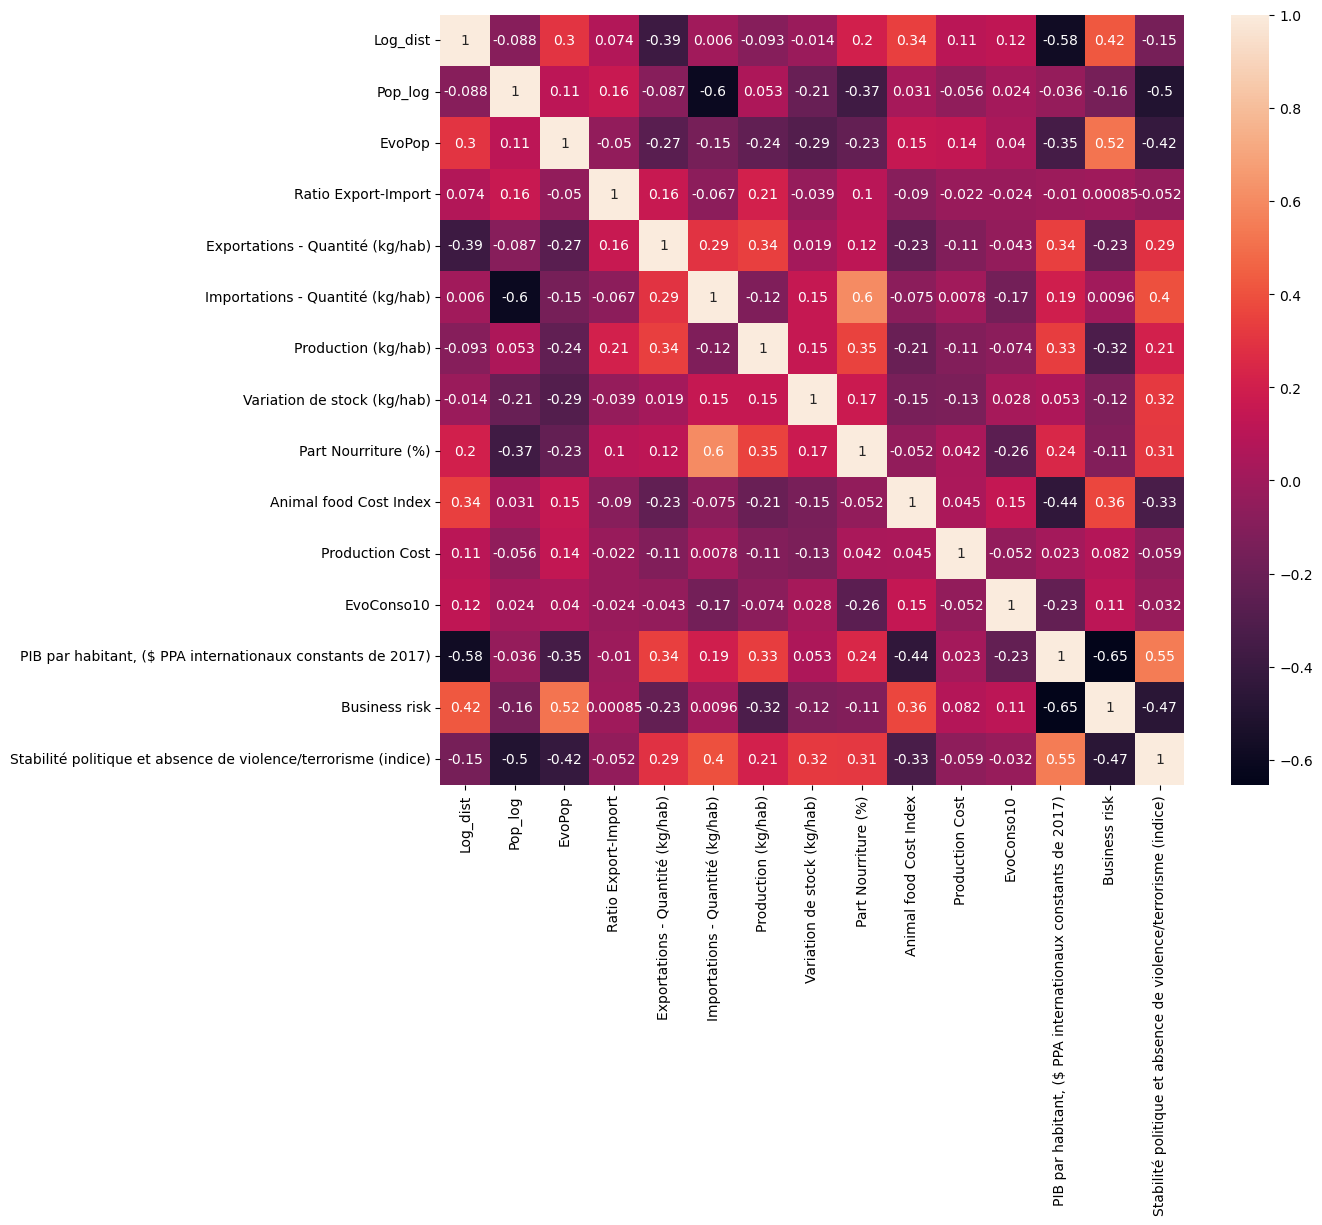

In [87]:
plt.figure(figsize= (12,10))
X_heatmap = pd.DataFrame(X,columns=DataFinal_out.iloc[:,3:].columns)
sns.heatmap(X_heatmap.corr(),annot=True)

In [88]:
DataFinal_out

,Code ISO3,Groupe de pays,Zone,Log_dist,Pop_log,EvoPop,Ratio Export-Import,Exportations - Quantité (kg/hab),Importations - Quantité (kg/hab),Production (kg/hab),Variation de stock (kg/hab),Part Nourriture (%),Animal food Cost Index,Production Cost,EvoConso10,"PIB par habitant, ($ PPA internationaux constants de 2017)",Business risk,Stabilité politique et absence de violence/terrorisme (indice)
0,ARM,Asie,Arménie,8.141481,7.990152,0.386412,0.000000,0.000000,11.857393,3.726609,-0.677565,1.595771,0.9730,819.5,1.907957,12715.1,47.0,-0.44
1,AFG,Asie,Afghanistan,8.628735,10.523309,2.984051,0.087121,0.067255,0.780159,0.753257,0.000000,0.428200,0.8505,1316.0,-1.837373,2033.8,173.0,-2.76
2,ALB,Europe,Albanie,7.379632,7.966497,-0.180090,0.000000,0.000000,13.181903,4.509599,1.387569,1.297908,1.2040,2829.8,0.726132,13317.1,82.0,0.37
3,DZA,Afrique,Algérie,7.200425,10.650848,2.051651,0.000000,0.000000,0.047361,6.512204,0.000000,0.798788,0.9640,1316.0,-1.266553,11630.7,157.0,-0.84
4,AGO,Afrique,Angola,8.781095,10.335588,3.469693,0.000000,0.000000,8.990650,1.363203,0.000000,1.849549,1.0110,1316.0,-0.916974,6982.1,177.0,-0.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,BEL,Europe,Belgique,5.568345,9.348551,0.587907,1.940828,57.132018,29.436924,40.323360,-0.522549,1.245397,0.7450,1030.1,0.655120,51139.1,46.0,0.40
168,LUX,Europe,Luxembourg,5.666427,6.403980,2.181583,0.090909,1.654958,18.204536,0.000000,0.000000,1.853350,0.6560,3977.5,0.321323,115050.0,72.0,1.36
169,SRB,Europe,Serbie,7.278629,9.082820,-0.257724,0.583333,0.795206,1.363210,9.656069,0.000000,1.363941,0.9980,1045.3,5.521856,17452.8,44.0,0.01
170,MNE,Europe,Monténégro,8.628018,6.442236,0.050103,0.000000,0.000000,12.742729,6.371365,1.592841,1.471387,0.8620,1316.0,1.877218,20686.6,95.5,0.04


## Détermination du nombre de composante, éboulis des valeurs propres

In [89]:
col=DataFinal_out.iloc[:,3:].columns
#On stock le nom des colonnes/dimensions dans une variable


In [90]:
# Analyse des valeurs propres
Summary = pd.DataFrame(
    {
        "Dimension" : ['F' + str(i+1)  for i in range(0, len(pca.explained_variance_))], 
        "Valeur propre" : pca.explained_variance_,
        "% variance expliquée" : np.round(pca.explained_variance_ratio_ * 100),
        "% cum. var. expliquée" : np.round(np.cumsum(pca.explained_variance_ratio_) * 100)
    },
    columns = ["Dimension", "Valeur propre", "% variance expliquée", "% cum. var. expliquée"]
)
Summary

,Dimension,Valeur propre,% variance expliquée,% cum. var. expliquée
0,F1,3.839322,25.0,25.0
1,F2,2.254201,15.0,40.0
2,F3,1.393394,9.0,50.0
3,F4,1.314437,9.0,58.0
4,F5,1.065657,7.0,65.0
5,F6,0.941983,6.0,72.0
6,F7,0.870885,6.0,77.0
7,F8,0.762945,5.0,82.0
8,F9,0.704508,5.0,87.0
9,F10,0.516647,3.0,91.0


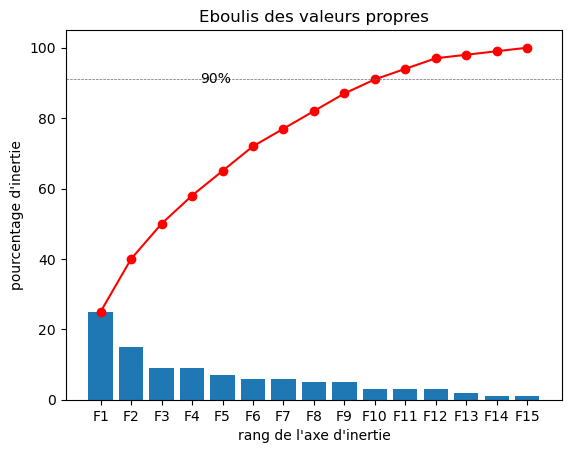

In [91]:
plt.bar(Summary['Dimension'], Summary['% variance expliquée'])
plt.plot(Summary['Dimension'], Summary['% cum. var. expliquée'],c="red",marker='o')
plt.axhline(y = 91, linewidth = .5, color = "dimgray", linestyle = "--")
plt.text(3.25, 90, "90%")
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

Afin de conserver 90 % des informations du jeu de données, nous devons conserver 10 variables parmis les 15 disponibles.

# Cercles de corrélations et composantes principales

In [92]:

#Calcul du cosinus carré des variables
pcs = pd.DataFrame(np.square(pca.components_),columns=col)

pcs.index = [f"F{i}" for i in Summary.index]
pcs.round(2)



,Log_dist,Pop_log,EvoPop,Ratio Export-Import,Exportations - Quantité (kg/hab),Importations - Quantité (kg/hab),Production (kg/hab),Variation de stock (kg/hab),Part Nourriture (%),Animal food Cost Index,Production Cost,EvoConso10,"PIB par habitant, ($ PPA internationaux constants de 2017)",Business risk,Stabilité politique et absence de violence/terrorisme (indice)
F0,0.07,0.02,0.10,0.00,0.08,0.05,0.06,0.03,0.06,0.07,0.00,0.02,0.16,0.13,0.15
F1,0.12,0.26,0.00,0.01,0.01,0.23,0.02,0.02,0.16,0.03,0.01,0.00,0.03,0.08,0.03
F2,0.10,0.04,0.00,0.37,0.01,0.01,0.26,0.00,0.14,0.00,0.00,0.02,0.01,0.00,0.03
F3,0.02,0.00,0.08,0.00,0.00,0.03,0.02,0.26,0.01,0.01,0.21,0.27,0.06,0.00,0.02
F4,0.07,0.02,0.01,0.04,0.39,0.07,0.01,0.08,0.03,0.00,0.13,0.05,0.01,0.08,0.01
F5,0.01,0.01,0.00,0.04,0.02,0.01,0.01,0.02,0.01,0.00,0.43,0.39,0.01,0.00,0.05
F6,0.00,0.01,0.14,0.07,0.01,0.00,0.01,0.14,0.03,0.52,0.00,0.01,0.00,0.04,0.01
F7,0.01,0.01,0.23,0.30,0.01,0.02,0.31,0.02,0.01,0.02,0.03,0.02,0.01,0.01,0.00
F8,0.07,0.00,0.01,0.04,0.14,0.00,0.05,0.28,0.01,0.03,0.17,0.03,0.02,0.07,0.08
F9,0.00,0.22,0.00,0.03,0.00,0.15,0.03,0.02,0.15,0.08,0.00,0.14,0.00,0.01,0.17


**Contribution des variables à la formation des axes (CTR)**

La contribution des variables à la formation des axes indique l'importance relative de chaque variable pour expliquer la variabilité des données sur un axe principal donné

In [93]:
# Contribution à la formation de l'axe

# Obtenir les composantes principales
components = pca.components_

n_components = X.shape[1]
feature_names=col

# Calculer la contribution des variables à la formation des axes
loadings = pca.components_.T
eigenvalues = pca.explained_variance_
variable_contributions = (loadings**2) * eigenvalues

# Créer un DataFrame pour faciliter l'affichage des résultats
column_names = [f'F{i+1}_contrib' for i in range(n_components)]
variable_contrib_df = pd.DataFrame(variable_contributions, columns=column_names, index=feature_names)


variable_contrib_df=variable_contrib_df.T
variable_contrib_df['Moy']=variable_contrib_df.mean(axis=1)
variable_contrib_df


,Log_dist,Pop_log,EvoPop,Ratio Export-Import,Exportations - Quantité (kg/hab),Importations - Quantité (kg/hab),Production (kg/hab),Variation de stock (kg/hab),Part Nourriture (%),Animal food Cost Index,Production Cost,EvoConso10,"PIB par habitant, ($ PPA internationaux constants de 2017)",Business risk,Stabilité politique et absence de violence/terrorisme (indice),Moy
F1_contrib,0.252930,0.093357,0.401523,0.002609,0.300619,0.191754,0.220935,0.110644,0.214269,2.863435e-01,0.015571,0.060449,0.632509,0.486282,0.569529,0.255955
F2_contrib,0.265501,0.590611,0.005743,0.020782,0.012012,0.524968,0.038952,0.050221,0.351330,5.869354e-02,0.019712,0.003463,0.067279,0.176102,0.068832,0.150280
F3_contrib,0.140093,0.053715,0.000263,0.517610,0.020420,0.007442,0.362805,0.002024,0.196403,3.292059e-03,0.001698,0.029199,0.014175,0.006584,0.037672,0.092893
F4_contrib,0.030766,0.001300,0.109908,0.000084,0.003623,0.037055,0.023078,0.342020,0.017433,1.824429e-02,0.278126,0.350541,0.075369,0.001867,0.025022,0.087629
F5_contrib,0.071945,0.019026,0.014802,0.047946,0.419826,0.076234,0.011950,0.080314,0.027649,1.273539e-04,0.141642,0.048807,0.010509,0.087912,0.006967,0.071044
F6_contrib,0.009923,0.012809,0.000851,0.037830,0.016157,0.005858,0.005915,0.018150,0.009514,2.218052e-03,0.402475,0.369567,0.005475,0.001708,0.043533,0.062799
F7_contrib,0.000364,0.010141,0.118925,0.064385,0.010089,0.001966,0.008012,0.120728,0.030038,4.549868e-01,0.000095,0.008283,0.002831,0.034964,0.005076,0.058059
F8_contrib,0.008993,0.004432,0.176135,0.230631,0.004133,0.013373,0.232818,0.017424,0.008081,1.199447e-02,0.023248,0.016677,0.008287,0.004373,0.002344,0.050863
F9_contrib,0.050605,0.000003,0.003951,0.031527,0.098325,0.003412,0.038653,0.195886,0.005119,1.808588e-02,0.118991,0.024336,0.013461,0.048843,0.053310,0.046967
F10_contrib,0.000008,0.112399,0.000212,0.015803,0.000178,0.076644,0.015520,0.010478,0.079252,4.098473e-02,0.000701,0.072149,0.000379,0.005170,0.086769,0.034443


En interprétant les contributions des variable à la formation des axes, on peut mettre en avant **les variables qui ont une contribution supérieure à la moyenne** ce qui nous aide à déterminer l'influence des variables d'origine sur les nouvelles composantes.

In [94]:
comparison_result = variable_contrib_df.gt(variable_contrib_df['Moy'], axis=0)
comparison_result.iloc[:,:-1] 

,Log_dist,Pop_log,EvoPop,Ratio Export-Import,Exportations - Quantité (kg/hab),Importations - Quantité (kg/hab),Production (kg/hab),Variation de stock (kg/hab),Part Nourriture (%),Animal food Cost Index,Production Cost,EvoConso10,"PIB par habitant, ($ PPA internationaux constants de 2017)",Business risk,Stabilité politique et absence de violence/terrorisme (indice)
F1_contrib,False,False,True,False,True,False,False,False,False,True,False,False,True,True,True
F2_contrib,True,True,False,False,False,True,False,False,True,False,False,False,False,True,False
F3_contrib,True,False,False,True,False,False,True,False,True,False,False,False,False,False,False
F4_contrib,False,False,True,False,False,False,False,True,False,False,True,True,False,False,False
F5_contrib,True,False,False,False,True,True,False,True,False,False,True,False,False,True,False
F6_contrib,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False
F7_contrib,False,False,True,True,False,False,False,True,False,True,False,False,False,False,False
F8_contrib,False,False,True,True,False,False,True,False,False,False,False,False,False,False,False
F9_contrib,True,False,False,False,True,False,False,True,False,False,True,False,False,True,True
F10_contrib,False,True,False,False,False,True,False,False,True,True,False,True,False,False,True


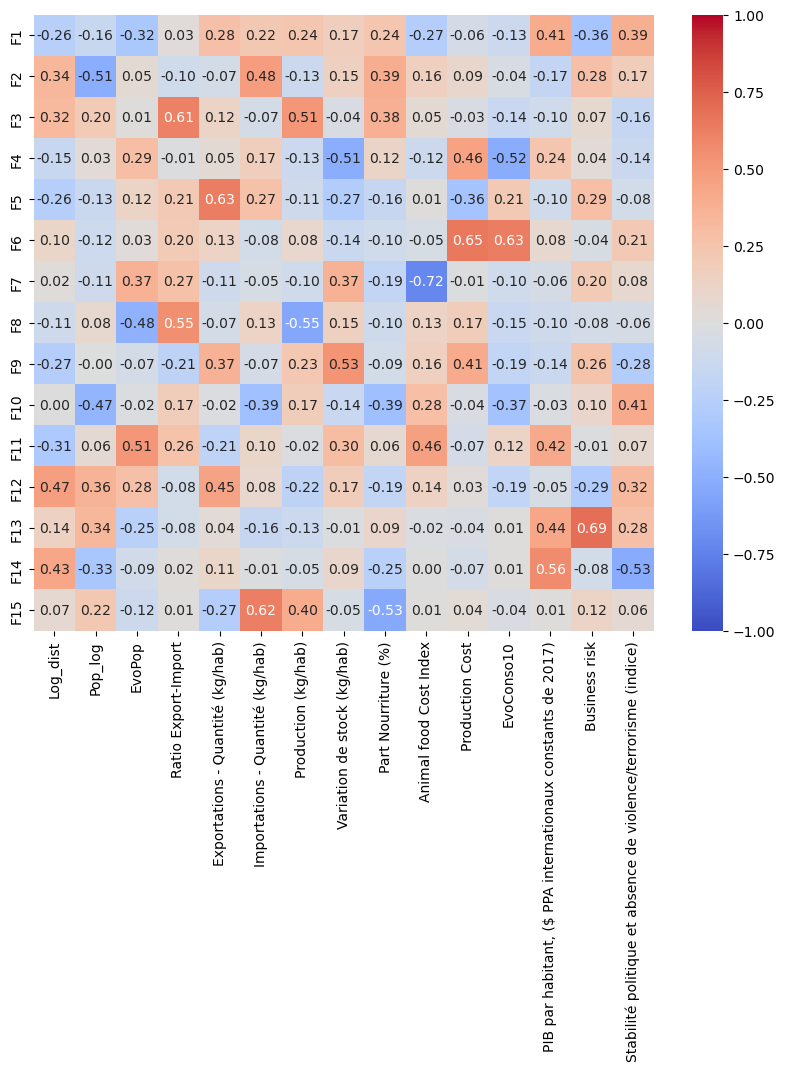

In [95]:
#Autre représentation sous forme de carte de chaleur.
pcs = pd.DataFrame(pca.components_)
pcs.columns=col
pcs.index = [f"F{i}" for i in range(1,len(col)+1)]
pcs.round(2)
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(pcs, vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")
plt.show()

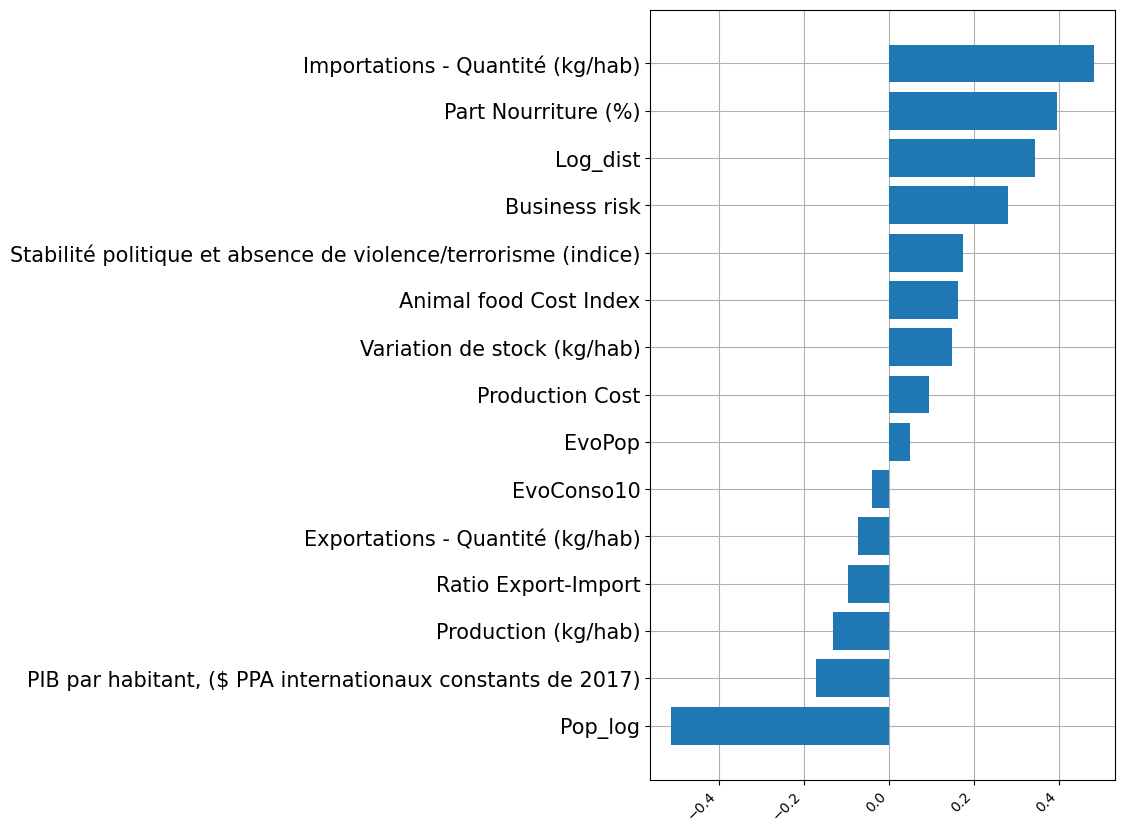

In [96]:

pcsF2=pcs.loc['F2'].sort_values()
plt.figure(figsize=(6,10))


plt.barh(width= pcsF2.values    ,y=pcsF2.index,zorder=2)
plt.xticks(rotation=45,ha='right')
plt.yticks(fontsize=15)
plt.grid()
plt.show()


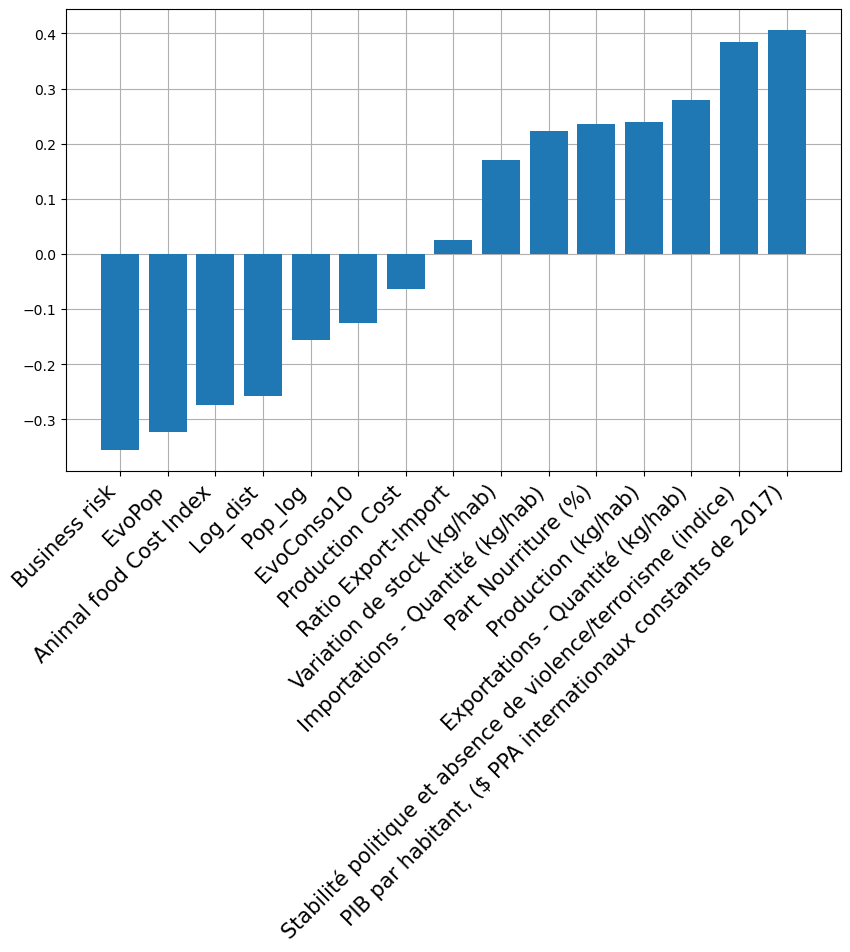

In [97]:
pcsF1=pcs.loc['F1'].sort_values()
plt.figure(figsize=(10,6))


plt.bar(height= pcsF1.values     ,x=pcsF1.index,zorder=2)
plt.xticks(rotation=45,ha='right',fontsize=15)
plt.grid()
plt.show()

## Représentations graphiques 

In [98]:
def correlation_graph (pca,
                       x_y,
                      features):
    
  
    
    x,y=x_y
    # Taille de l'image (en inches)
    plt.figure(figsize =(10,10))

    # Pour chaque composante : 
    for i in range(0, pca.components_.shape[1]):

        # Les flèches
        plt.arrow(0,0, 
                pca.components_[x, i],  
                pca.components_[y, i],  
                head_width=0.02,
                head_length=0.03 )

        # Les labels
        plt.annotate(col[i],(pca.components_[x, i]+0.015 ,
                pca.components_[y, i]+0.015))
        
    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

    # Titre
    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

    # Le cercle 
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

    # Axes et display
    plt.axis('equal')
    plt.show(block=False)

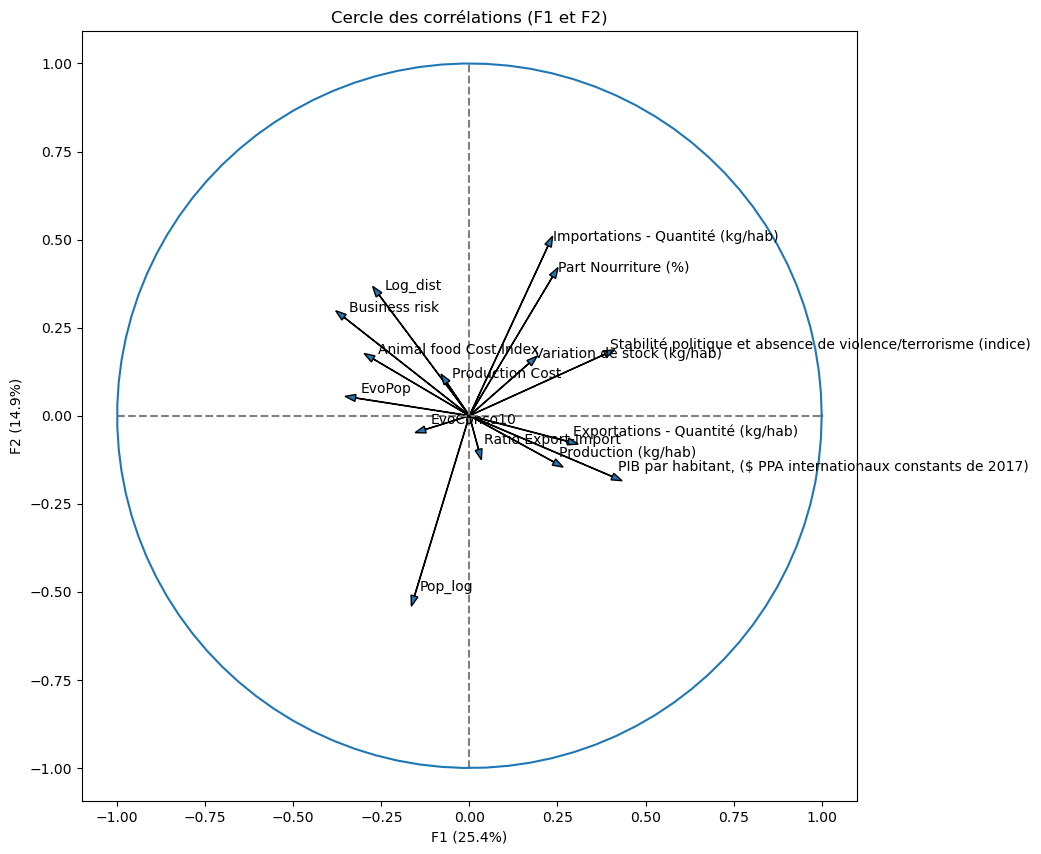

In [99]:
# Cercle correlation sur F1,F2
x_y = (0,1)

correlation_graph(pca, x_y, col)

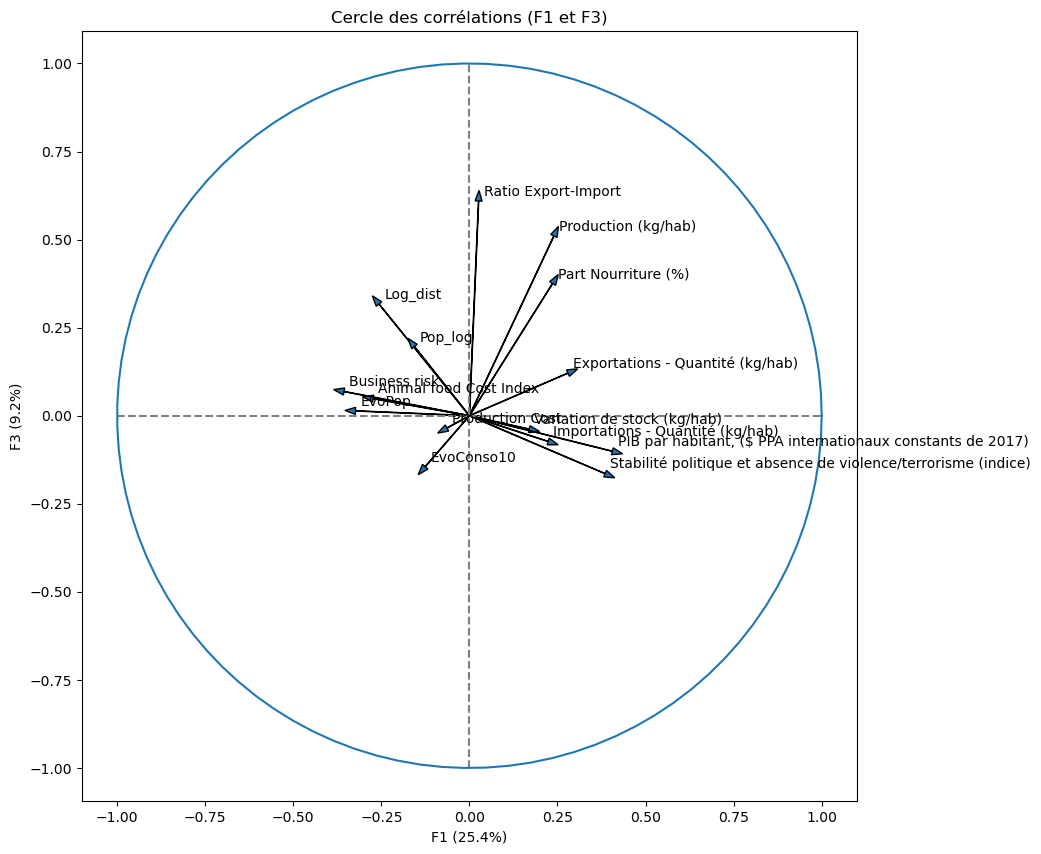

In [100]:
# Cercle correlation sur F2,F3
x_y = (0,2)
x_y
correlation_graph(pca, x_y, col)

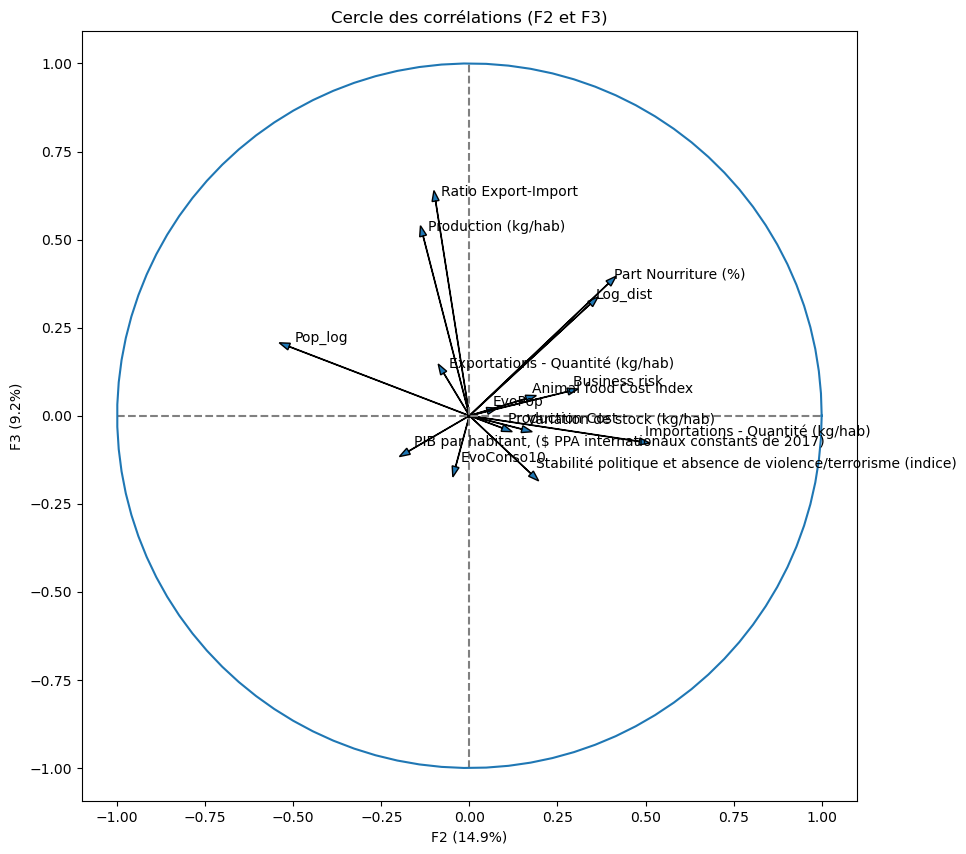

In [101]:
# Cercle correlation sur F1,F3
x_y = (1,2)
x_y
correlation_graph(pca, x_y, col)

In [102]:
def display_factorial_planes(   X_pca, 
                                x_y, 
                                pca=None, 
                                labels = None,
                                clusters=None, 
                                alpha=1,
                                figsize=[13,13], 
                                marker="." ):
    """
    Affiche la projection des individus

    Positional arguments : 
    -------------------------------------
    X_projected : np.array, pd.DataFrame, list of list : la matrice des points projetés
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2

    Optional arguments : 
    -------------------------------------
    pca : sklearn.decomposition.PCA : un objet PCA qui a été fit, cela nous permettra d'afficher la variance de chaque composante, default = None
    labels : list ou tuple : les labels des individus à projeter, default = None
    clusters : list ou tuple : la liste des clusters auquel appartient chaque individu, default = None
    alpha : float in [0,1] : paramètre de transparence, 0=100% transparent, 1=0% transparent, default = 1
    figsize : list ou tuple : couple width, height qui définit la taille de la figure en inches, default = [10,8] 
    marker : str : le type de marker utilisé pour représenter les individus, points croix etc etc, default = "."
    """

    # Transforme X_projected en np.array
    X_ = np.array(X_pca)

    # On définit la forme de la figure si elle n'a pas été donnée
    if not figsize: 
        figsize = (12,12)

    # On gère les labels
    if  labels is None : 
        labels = []
    try : 
        len(labels)
    except Exception as e : 
        raise e

    # On vérifie la variable axis 
    if not len(x_y) ==2 : 
        raise AttributeError("2 axes sont demandées")   
    if max(x_y )>= X_.shape[1] : 
        raise AttributeError("la variable axis n'est pas bonne")   

    # on définit x et y 
    x, y = x_y

    # Initialisation de la figure       
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # On vérifie s'il y a des clusters ou non
    c = None if clusters is None else clusters
    
    
    # Traçage des points
    unique_hues = c.unique()

    # Set up the color palette
    palette = sns.color_palette("tab10", len(unique_hues))
        
    # Les points    
    sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c,s= 165,palette=palette)

    # on peut calculer le % de variance de chaque axe 
    if pca : 
        v1 = str(round(100*pca.explained_variance_ratio_[x]))  + " %"
        v2 = str(round(100*pca.explained_variance_ratio_[y]))  + " %"
    else : 
        v1=v2= ''

    # Nom des axes, avec le pourcentage d'inertie expliqué
    ax.set_xlabel(f'F{x+1} {v1}')
    ax.set_ylabel(f'F{y+1} {v2}')
  
    
    # Valeur x max et y max
    x_max = np.abs(X_[:, x]).max() *1.1
    y_max = np.abs(X_[:, y]).max() *1.1
   
    # On borne x et y 
    plt.xlim(left=-x_max, right=x_max)
    plt.ylim(bottom= -y_max, top=y_max)
    

    
    # Affichage des lignes horizontales et verticales
    plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8)
    plt.plot([0,0], [-y_max, y_max], color='grey', alpha=0.8)
      
        
    # Affichage des labels des points

    
    
    if len(labels) : 
        
    # Add annotations
     #for category in unique_hues:
     # subset = X_[c == category]
     #color = palette[unique_hues.tolist().index(category)]
        for i, (_x, _y) in enumerate(X_[:, [x, y]]):
            plt.text(_x, _y + 0.05, labels[i], fontsize='8', ha='left', va='center', color='#129199')
                                
    
   
    # Titre et display
    plt.title(f"Projection des individus (sur F{x+1} et F{y+1})")
    # Afficher la légende
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.show()
    

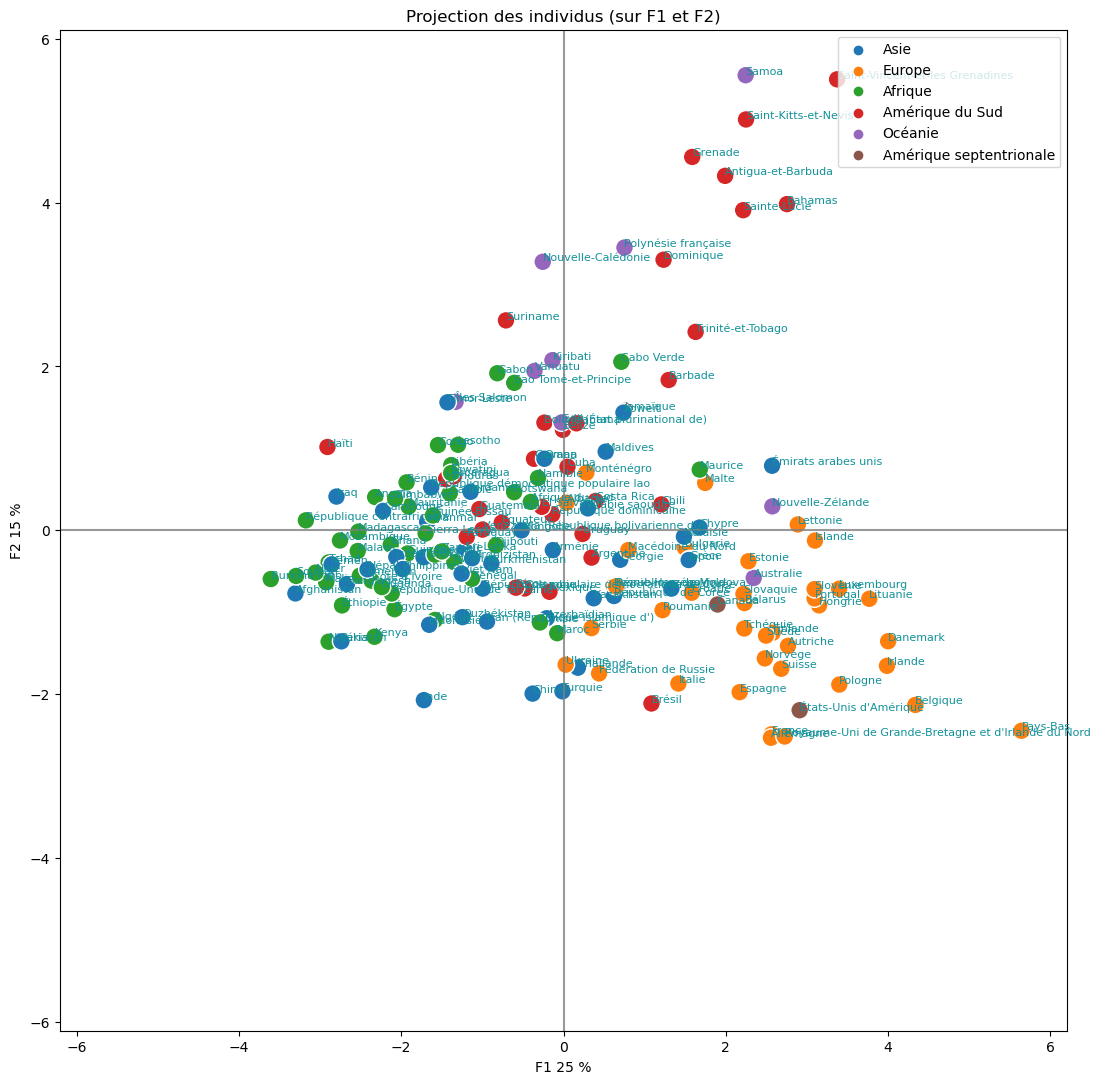

In [103]:
x_y = [0, 1]
display_factorial_planes(X_pca,
                         x_y,
                         pca,
                         labels=DataFinal_out.Zone.values,
                         clusters = DataFinal_out['Groupe de pays'],
                         marker="o")


On liste les pays par "cadran" sur le plan F1/F2

In [104]:
corr_circle_df =pd.DataFrame(X_pca[:,[0,1]],index=DataFinal_out['Zone'],columns=['x','y'])
corr_circle_df[(corr_circle_df['x']>0) & (corr_circle_df['y']>0)].index


#mydict={'pays':str(corr_circle_df[(corr_circle_df['x']>0) & (corr_circle_df['y']>0)].index.values)}
dflistcirc= pd.DataFrame()
dflistcirc.at[0,'Pays'] =str(corr_circle_df[(corr_circle_df['x']<0) & (corr_circle_df['y']>0)].index.values)
dflistcirc.at[1,'Pays'] =str(corr_circle_df[(corr_circle_df['x']>0) & (corr_circle_df['y']>0)].index.values)
dflistcirc.at[2,'Pays'] =str(corr_circle_df[(corr_circle_df['x']>0) & (corr_circle_df['y']<0)].index.values)
dflistcirc.at[3,'Pays'] =str(corr_circle_df[(corr_circle_df['x']<0) & (corr_circle_df['y']<0)].index.values)
dflistcirc.style.set_properties(subset=['Pays'], **{'width': '500px'})
dflistcirc

,Pays
0,['Angola' 'Bolivie (État plurinational de)' 'Botswana' 'Belize'\n 'Îles Salomon' 'Myanmar' 'République centrafricaine' 'Congo' 'Bénin'\n 'République dominicaine' 'Équateur' 'El Salvador' 'Fidji' 'Gabon'\n 'Gambie' 'Kiribati' 'Guatemala' 'Guyana' 'Haïti' 'Honduras' 'Iraq'\n 'Jordanie' 'Cambodge' 'République démocratique populaire lao' 'Lesotho'\n 'Libéria' 'Mauritanie' 'Namibie' 'Nouvelle-Caléd...
1,['Albanie' 'Antigua-et-Barbuda' 'Bahamas' 'Barbade' 'Cabo Verde' 'Chili'\n 'Costa Rica' 'Cuba' 'Chypre' 'Dominique' 'Polynésie française' 'Grenade'\n 'Jamaïque' 'Koweït' 'Lettonie' 'Maldives' 'Malte' 'Maurice'\n 'Nouvelle-Zélande' 'Panama' 'Saint-Kitts-et-Nevis' 'Sainte-Lucie'\n 'Saint-Vincent-et-les Grenadines' 'Arabie saoudite' 'Trinité-et-Tobago'\n 'Émirats arabes unis' 'Samoa' 'Monténégro']
2,['Argentine' 'Australie' 'Autriche' 'Brésil' 'Bulgarie' 'Canada'\n 'Danemark' 'Bélarus' 'Estonie' 'Finlande' 'France' 'Géorgie' 'Allemagne'\n 'Bosnie-Herzégovine' 'Grèce' 'Hongrie' 'Croatie' 'Islande' 'Irlande'\n 'Israël' 'Italie' 'Kazakhstan' 'Japon' 'République de Corée' 'Lituanie'\n 'Malaisie' 'République de Moldova' 'Pays-Bas' 'Macédoine du Nord'\n 'Norvège' 'Tchéquie' 'Pologne' 'Portugal'...
3,"['Arménie' 'Afghanistan' 'Algérie' 'Bangladesh' 'Cameroun' 'Sri Lanka'\n 'Tchad' 'Chine' 'Colombie' 'Azerbaïdjan' 'Égypte' 'Djibouti' 'Ghana'\n 'Guinée' 'Inde' 'Indonésie' ""Iran (République islamique d')""\n ""Côte d'Ivoire"" 'Kirghizistan' 'Kenya'\n 'République populaire démocratique de Corée' 'Liban' 'Madagascar'\n 'Malawi' 'Mali' 'Mexique' 'Mongolie' 'Maroc' 'Mozambique' 'Népal' 'Niger'\n 'Nig..."


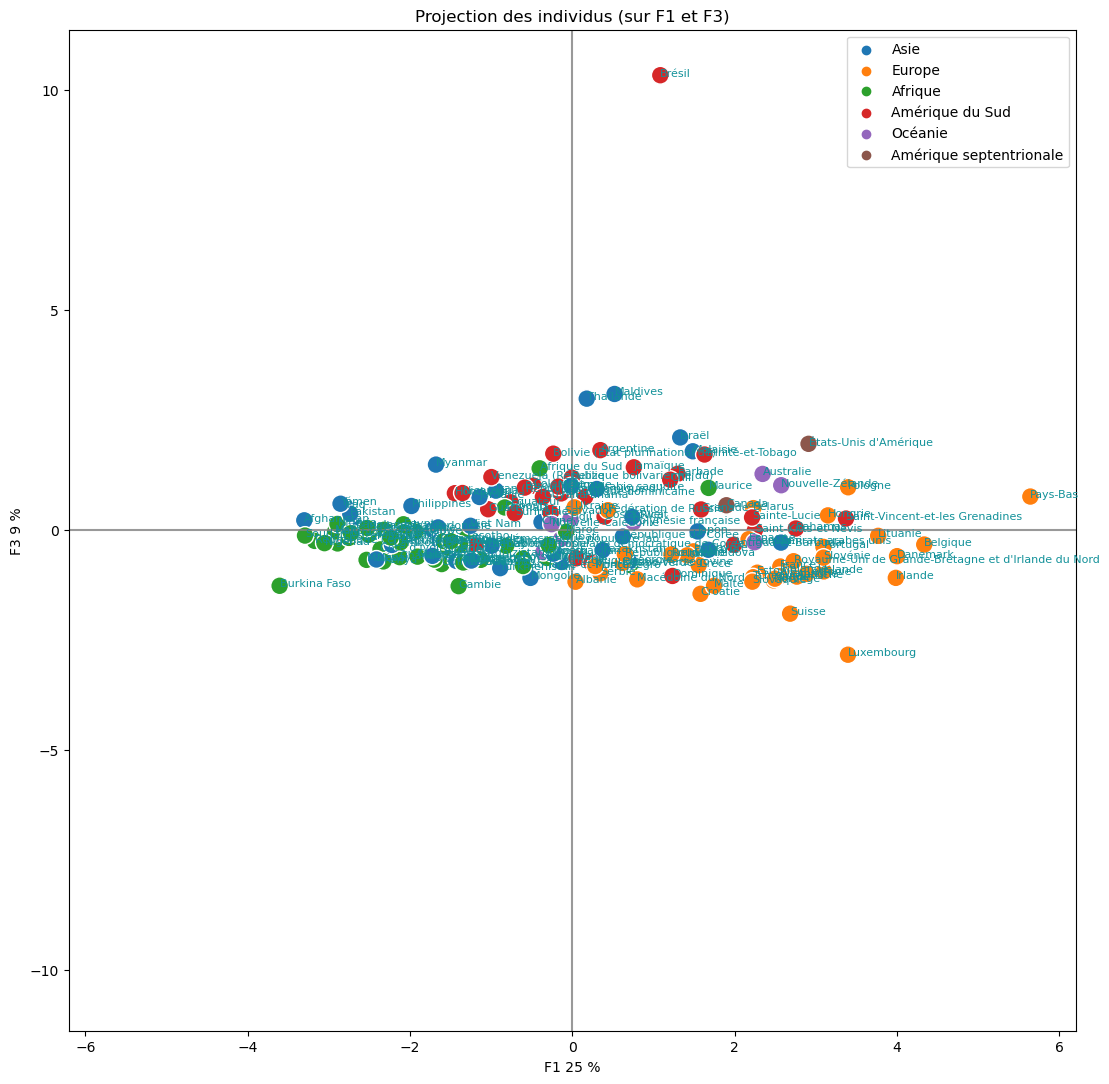

In [105]:
x_y = [0, 2]
display_factorial_planes(X_pca,
                         x_y,
                         pca,
                         
                         labels=DataFinal_out.Zone.values,
                         clusters = DataFinal_out['Groupe de pays'],
                         marker="o")

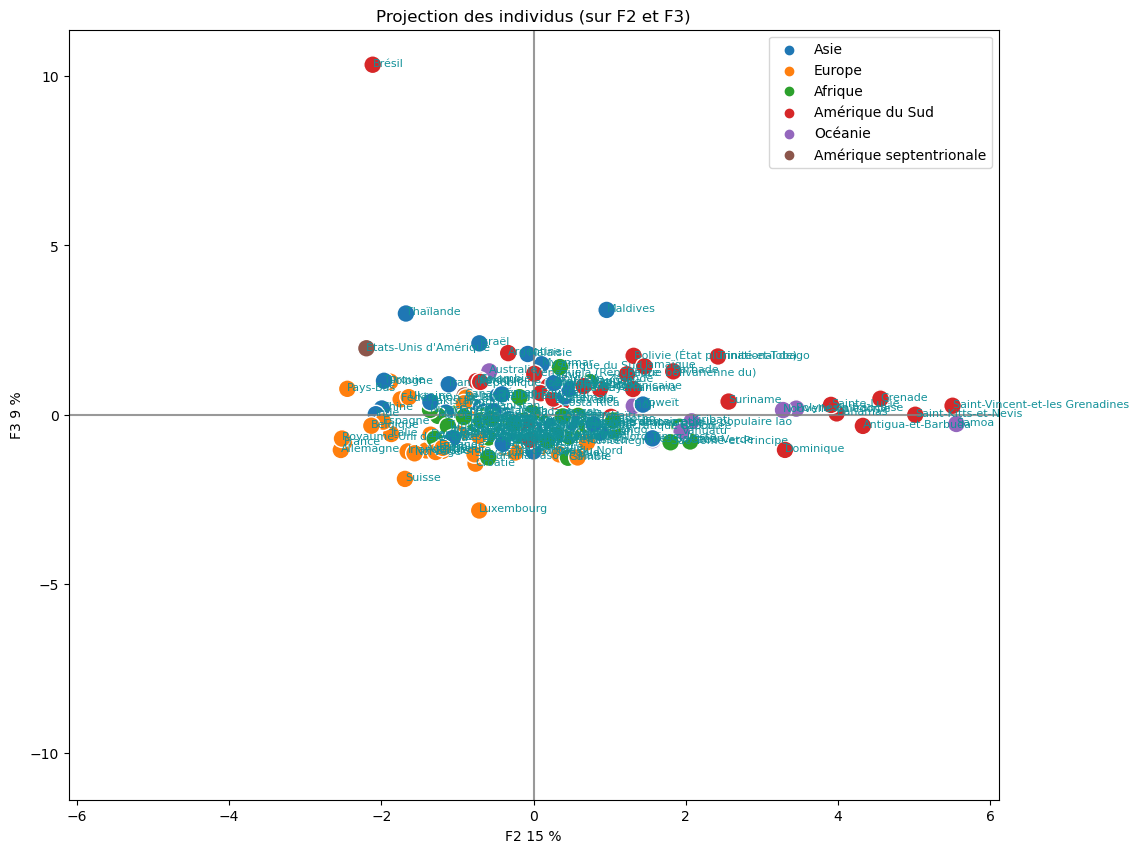

In [106]:
x_y = [1,2]
display_factorial_planes(X_pca,
                         x_y,
                         pca,
                         labels=DataFinal_out.Zone.values,
                         figsize=(12, 10),
                         clusters = DataFinal_out['Groupe de pays'],
                         marker="o")

In [107]:
DataFinal.to_csv('Classification_source.csv',index=False)

In [108]:
def Circle_projection (pca, x_y,figsize ):

    


    X_ = np.array(X_pca)


    coeff = np.transpose(pca.components_[0:2, :])
    n = coeff.shape[0]

    
    
    #choix des composantes
    x, y = x_y
    # Créer la figure
    fig, ax = plt.subplots(figsize=figsize)

    # Visualiser les catégories  avec les couleurs
    colors = ['r', 'g', 'b']
    lw = 2

    # Visualiser les individus
    sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y],s= 165)

    if pca : 
        v1 = str(round(100*pca.explained_variance_ratio_[x]))  + " %"
        v2 = str(round(100*pca.explained_variance_ratio_[y]))  + " %"
    else : 
        v1=v2= ''

    # Nom des axes, avec le pourcentage d'inertie expliqué
    ax.set_xlabel(f'F{x+1} {v1}')
    ax.set_ylabel(f'F{y+1} {v2}')
  
    
    # Valeur x max et y max
    x_max = np.abs(X_[:, x]).max() *1.1
    y_max = np.abs(X_[:, y]).max() *1.1

    # On borne x et y 
    plt.xlim(left=-x_max, right=x_max)
    plt.ylim(bottom= -y_max, top=y_max)

    # Placer les vecteurs des variables
    for i in range(0, pca.components_.shape[1]):

            # Les flèches
            plt.arrow(0,0, 
                    pca.components_[x, i]*10,  
                    pca.components_[y, i]*10,  
                    head_width=0.07,
                    head_length=0.07, 
                    width=0.02, )

            # Les labels
            plt.text(pca.components_[x, i]*11 + 0.05,
                    pca.components_[y, i]*11 + 0.05,
                    col[i],ha='left')

            
            
            
    for i, (_x, _y) in enumerate(X_[:, [x, y]]):
            plt.text(_x, _y + 0.3, DataFinal_out.Zone.values[i], fontsize='8', ha='left', va='top', color='#129199')

    # Placer le cercle unitaire
    
    circle = plt.Circle((0, 0), 5, color='gray', fill=False, linestyle='--')
    plt.gca().add_artist(circle)



    # Ajuster les limites et les axes
    #plt.xlim(-3, 3)
    #plt.ylim(-3, 3)
    plt.axhline(0, color='gray', linewidth=1)
    plt.axvline(0, color='gray', linewidth=1)
    
    plt.title('ACP avec cercle de corrélation et nuage des individus par continent')

    # Afficher la légende
    plt.legend(loc='best', shadow=False, scatterpoints=1)

    # Afficher la figure
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


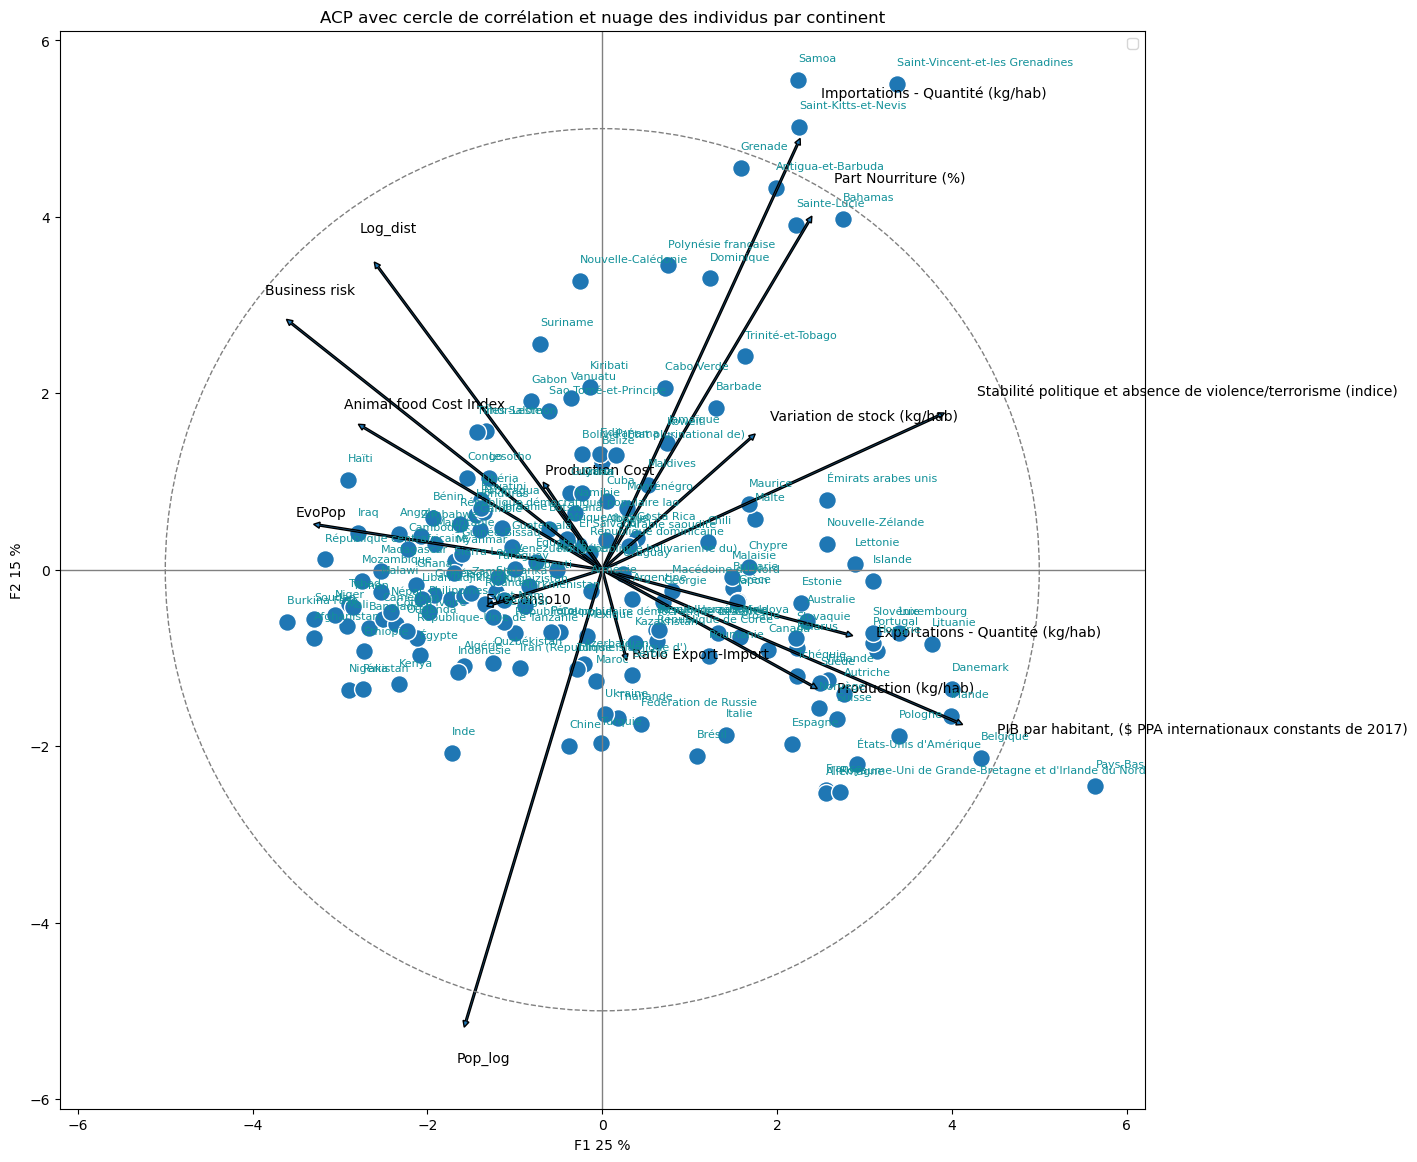

In [109]:
Circle_projection ( pca,(0,1),(14,14) )

In [110]:
data_ACP = pd.DataFrame(X_pca,columns=pcs.index,index=DataFinal_out['Zone'])
data_ACP=data_ACP.iloc[:,:-5]
data_ACP

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10
Zone,,,,,,,,,,
Arménie,-0.131482,-0.243094,-0.721597,-0.244223,0.263156,-0.806910,-0.849098,0.739169,-0.803020,0.417696
Afghanistan,-3.303697,-0.771362,0.225113,1.144942,0.600390,-1.499011,0.881026,-0.010938,0.819971,-0.567190
Albanie,0.038651,0.336102,-1.170443,0.475297,-0.645851,0.711255,-1.377350,1.720095,1.132707,1.099769
Algérie,-1.584300,-1.095427,-0.484071,0.821990,0.557598,-1.122728,0.151644,0.264003,0.683628,0.375481
Angola,-2.321143,0.404836,0.009901,0.881798,0.472775,-0.877484,0.516474,-0.353589,-0.006664,0.320636
...,...,...,...,...,...,...,...,...,...,...
Belgique,4.335250,-2.132642,-0.325111,1.228489,4.431601,0.136542,-0.954610,-0.588396,2.065945,0.010716
Luxembourg,3.395914,-0.714750,-2.828933,3.896288,-0.775071,2.439951,0.868251,0.292398,0.295975,0.739841
Serbie,0.344659,-1.195073,-0.978718,-0.784406,0.136185,-0.147175,-1.173920,0.850251,-0.400964,0.409658


## Export du fichier pour classification

In [111]:

data_ACP.to_csv('Classification_source_ACP.csv',index=True)